# Imports

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
from sklearn.metrics import r2_score
from statsmodels.nonparametric.smoothers_lowess import lowess

from functools import reduce
import statsmodels.api as sm
import seaborn as sns
from numpy import sqrt
from numpy.linalg import inv
from patsy import dmatrix

from statsmodels.stats.outliers_influence import variance_inflation_factor
plt.rcParams['font.family'] = 'Calibri'

# Data Frames

In [4]:
nba_df = pd.read_excel('csv/nba_statistics.csv')
nba_df.head()

,PLAYER,TEAM,GP,W,L,MIN,Dist. Feet,Dist. Miles,Dist. Miles Off,Dist. Miles Def,Avg Speed,Avg Speed Off,Avg Speed Def
0,Jesse Edwards,MIN,2,2,0,2.3,1088.5,0.21,0.12,0.09,4.66,3.80,6.04
1,Jahlil Okafor,IND,1,0,1,3.4,1483.0,0.28,0.13,0.15,4.74,3.70,5.53
2,Mac McClung,ORL,2,1,1,5.1,2146.5,0.41,0.23,0.18,4.32,4.76,4.98
3,Quincy Olivari,LAL,2,1,1,5.2,2239.0,0.42,0.24,0.19,4.24,4.67,4.89
4,Riley Minix,SAS,1,0,1,6.8,2831.0,0.54,0.28,0.25,4.23,5.32,4.87


In [5]:
team_dfs = {team: nba_df[nba_df['TEAM'] == team] for team in nba_df['TEAM'].unique()}


In [6]:
nba_standings = pd.read_excel('csv/NBA_2024_2025_standings_1_to_30.xlsx')
nba_standings.head()

,Place,Team - Full Name,TEAM,W,L,PCT
0,1,Oklahoma City Thunder,OKC,68,14,0.829
1,2,Cleveland Cavaliers,CLE,64,18,0.780
2,3,Boston Celtics,BOS,61,21,0.744
3,4,Houston Rockets,HOU,52,30,0.634
4,5,New York Knicks,NYK,51,31,0.622


In [7]:
dws = pd.read_excel('csv/DWS.xlsx')
dws.head()

,Player,TEAM,AGE,GP,W,L,MIN,DEF RTG,DREB,DREB%,%DREB,STL,STL%,BLK,%BLK,OPP PTS OFF TOV,OPP PTS 2ND CHANCE,OPP PTS FB,"OPP PTS, PAINT",DEF WS
0,Shai Gilgeous-Alexander,OKC,26,76,63,13,34.2,105.7,4.1,11.2,16.9,1.7,23.0,1.0,23.1,8.6,10.9,8.6,30.2,0.168
1,Franz Wagner,ORL,23,60,33,27,33.7,105.8,4.8,14.6,21.4,1.3,19.4,0.4,8.5,10.6,8.3,9.5,30.8,0.166
2,De'Anthony Melton,BKN,27,6,4,2,20.2,97.4,2.3,10.4,15.6,1.2,21.9,0.3,12.5,7.3,6.7,3.8,19.3,0.160
3,Jalen Williams,OKC,24,69,55,14,32.4,106.5,4.5,13.1,20.1,1.6,21.0,0.7,16.8,8.8,10.2,8.6,29.5,0.154
4,Jalen Suggs,ORL,24,35,20,15,28.6,104.8,3.4,12.6,18.2,1.5,23.2,0.9,23.6,11.2,6.3,7.7,27.4,0.152


In [8]:
ows = pd.read_csv('csv/offense.csv')
ows = ows.drop(columns=['Player-additional;;;;;;;;;;;;;;;;;;;', 'Awards'], errors='ignore')
ows.head()

,Rk,Player,Age,Team,Pos,G,GS,MP,PER,TS%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,1,Mikal Bridges,28,NYK,SF,82,82,3036,14.0,0.585,...,9.7,19.6,3.7,2.0,5.7,0.090,0.4,-0.9,-0.5,1.2
1,2,Josh Hart,29,NYK,SG,77,77,2897,16.5,0.611,...,15.5,15.3,5.4,3.8,9.2,0.153,1.1,1.8,2.8,3.6
2,3,Anthony Edwards,23,MIN,SG,79,79,2871,20.1,0.595,...,12.0,31.4,4.6,3.8,8.4,0.140,4.4,0.0,4.3,4.6
3,4,Devin Booker,28,PHO,SG,75,75,2795,19.3,0.589,...,11.9,29.3,6.1,0.3,6.4,0.111,2.8,-2.4,0.4,1.7
4,5,James Harden,35,LAC,PG,79,79,2789,20.0,0.582,...,18.0,29.6,4.0,4.3,8.3,0.143,3.5,0.8,4.3,4.4


## Initial Cleaning

In [9]:
nba_df.columns = nba_df.columns.str.replace(r'\s+', ' ', regex=True).str.strip()


# EDA

In [10]:
nba_df.shape

(569, 13)

In [11]:
nba_df.info

<bound method DataFrame.info of              PLAYER TEAM  GP   W   L   MIN  Dist. Feet  Dist. Miles  \
0     Jesse Edwards  MIN   2   2   0   2.3      1088.5         0.21   
1     Jahlil Okafor  IND   1   0   1   3.4      1483.0         0.28   
2       Mac McClung  ORL   2   1   1   5.1      2146.5         0.41   
3    Quincy Olivari  LAL   2   1   1   5.2      2239.0         0.42   
4       Riley Minix  SAS   1   0   1   6.8      2831.0         0.54   
..              ...  ...  ..  ..  ..   ...         ...          ...   
564      Chris Paul  SAS  82  34  48  27.9      9606.7         1.82   
565    Nikola Jokić  DEN  70  46  24  36.7     13128.7         2.49   
566    James Harden  LAC  79  50  29  35.3     11714.5         2.22   
567    Terry Taylor  SAC   3   1   2   2.1       791.7         0.15   
568   Terence Davis  SAC   1   1   0   7.9      2912.0         0.55   

     Dist. Miles Off  Dist. Miles Def  Avg Speed  Avg Speed Off  Avg Speed Def  
0               0.12             0

In [12]:
nba_df.isnull().sum()

PLAYER             0
TEAM               0
GP                 0
W                  0
L                  0
MIN                0
Dist. Feet         0
Dist. Miles        0
Dist. Miles Off    0
Dist. Miles Def    0
Avg Speed          0
Avg Speed Off      0
Avg Speed Def      0
dtype: int64

In [13]:
nba_df.describe()

,GP,W,L,MIN,Dist. Feet,Dist. Miles,Dist. Miles Off,Dist. Miles Def,Avg Speed,Avg Speed Off,Avg Speed Def
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,46.230228,23.235501,22.994728,19.430053,7829.875044,1.482900,0.790018,0.692882,4.300141,4.573480,4.038805
std,24.358778,15.596499,13.987103,9.538690,3710.590691,0.702978,0.379104,0.325762,0.228088,0.304315,0.272900
min,1.000000,0.000000,0.000000,0.900000,367.700000,0.070000,0.040000,0.030000,3.340000,3.670000,2.980000
25%,25.000000,10.000000,11.000000,11.800000,4809.100000,0.910000,0.490000,0.430000,4.170000,4.390000,3.880000
50%,50.000000,21.000000,23.000000,19.500000,7955.200000,1.510000,0.800000,0.700000,4.310000,4.580000,4.030000
75%,68.000000,36.000000,32.000000,27.200000,10869.800000,2.060000,1.090000,0.960000,4.440000,4.760000,4.180000
max,82.000000,64.000000,64.000000,37.700000,15273.300000,2.890000,1.660000,1.320000,5.150000,6.580000,6.040000


## Top 10 Statistics

In [14]:
nba_df.nlargest(10, 'Dist. Miles')

,PLAYER,TEAM,GP,W,L,MIN,Dist. Feet,Dist. Miles,Dist. Miles Off,Dist. Miles Def,Avg Speed,Avg Speed Off,Avg Speed Def
506,Tyrese Maxey,PHI,52,20,32,37.7,15273.3,2.89,1.66,1.23,4.28,4.76,3.76
245,Mikal Bridges,NYK,82,51,31,37.0,14878.1,2.82,1.54,1.28,4.30,4.51,4.08
343,Jalen Johnson,ATL,36,18,18,35.7,14763.8,2.80,1.48,1.31,4.39,4.83,3.97
380,Tyler Herro,MIA,77,37,40,35.4,14659.7,2.78,1.54,1.24,4.40,4.85,3.94
495,De'Aaron Fox,SAS,62,27,35,36.1,14513.2,2.75,1.48,1.27,4.25,4.75,3.78
460,Josh Hart,NYK,77,48,29,37.6,14470.8,2.74,1.51,1.23,4.11,4.37,3.84
153,Keegan Murray,SAC,76,36,40,34.3,14253.1,2.70,1.40,1.30,4.41,4.67,4.17
249,Dyson Daniels,ATL,76,37,39,33.8,14263.0,2.70,1.42,1.29,4.49,4.95,4.07
302,Franz Wagner,ORL,60,33,27,33.7,14117.8,2.67,1.50,1.18,4.43,4.84,4.01
515,Cade Cunningham,DET,70,38,32,35.0,14101.9,2.67,1.50,1.17,4.29,4.87,3.73


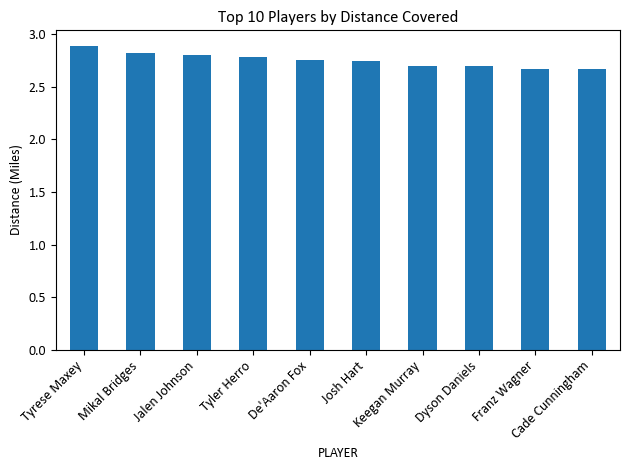

In [15]:


top10 = nba_df.nlargest(10, 'Dist. Miles')
top10.plot(x='PLAYER', y='Dist. Miles', kind='bar', legend=False)
plt.ylabel('Distance (Miles)')
plt.title('Top 10 Players by Distance Covered')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [16]:
nba_df.nlargest(10, 'Dist. Miles Off')

,PLAYER,TEAM,GP,W,L,MIN,Dist. Feet,Dist. Miles,Dist. Miles Off,Dist. Miles Def,Avg Speed,Avg Speed Off,Avg Speed Def
506,Tyrese Maxey,PHI,52,20,32,37.7,15273.3,2.89,1.66,1.23,4.28,4.76,3.76
245,Mikal Bridges,NYK,82,51,31,37.0,14878.1,2.82,1.54,1.28,4.30,4.51,4.08
380,Tyler Herro,MIA,77,37,40,35.4,14659.7,2.78,1.54,1.24,4.40,4.85,3.94
502,Jalen Brunson,NYK,65,40,25,35.4,13937.1,2.64,1.52,1.12,4.23,4.65,3.76
460,Josh Hart,NYK,77,48,29,37.6,14470.8,2.74,1.51,1.23,4.11,4.37,3.84
302,Franz Wagner,ORL,60,33,27,33.7,14117.8,2.67,1.50,1.18,4.43,4.84,4.01
515,Cade Cunningham,DET,70,38,32,35.0,14101.9,2.67,1.50,1.17,4.29,4.87,3.73
532,Devin Booker,PHX,75,35,40,37.3,14000.7,2.65,1.49,1.16,4.00,4.33,3.65
343,Jalen Johnson,ATL,36,18,18,35.7,14763.8,2.80,1.48,1.31,4.39,4.83,3.97
495,De'Aaron Fox,SAS,62,27,35,36.1,14513.2,2.75,1.48,1.27,4.25,4.75,3.78


In [17]:
nba_df.nlargest(10, 'Dist. Miles Def')

,PLAYER,TEAM,GP,W,L,MIN,Dist. Feet,Dist. Miles,Dist. Miles Off,Dist. Miles Def,Avg Speed,Avg Speed Off,Avg Speed Def
25,Toumani Camara,POR,78,33,45,32.7,14039.4,2.66,1.34,1.32,4.57,4.66,4.49
343,Jalen Johnson,ATL,36,18,18,35.7,14763.8,2.80,1.48,1.31,4.39,4.83,3.97
153,Keegan Murray,SAC,76,36,40,34.3,14253.1,2.70,1.40,1.30,4.41,4.67,4.17
249,Dyson Daniels,ATL,76,37,39,33.8,14263.0,2.70,1.42,1.29,4.49,4.95,4.07
245,Mikal Bridges,NYK,82,51,31,37.0,14878.1,2.82,1.54,1.28,4.30,4.51,4.08
495,De'Aaron Fox,SAS,62,27,35,36.1,14513.2,2.75,1.48,1.27,4.25,4.75,3.78
257,Kelly Oubre Jr.,PHI,60,21,39,34.6,13753.1,2.60,1.37,1.24,4.19,4.33,4.06
380,Tyler Herro,MIA,77,37,40,35.4,14659.7,2.78,1.54,1.24,4.40,4.85,3.94
323,Christian Braun,DEN,79,48,31,33.9,13713.5,2.60,1.37,1.23,4.35,4.72,3.99
394,Domantas Sabonis,SAC,70,36,34,34.7,13694.0,2.59,1.36,1.23,4.20,4.51,3.92


In [18]:
nba_df.nlargest(10, 'Avg Speed')

,PLAYER,TEAM,GP,W,L,MIN,Dist. Feet,Dist. Miles,Dist. Miles Off,Dist. Miles Def,Avg Speed,Avg Speed Off,Avg Speed Def
14,D.J. Carton,TOR,4,1,3,8.3,4031.5,0.76,0.41,0.36,5.15,5.42,4.57
354,James Wiseman,IND,1,1,0,4.6,2076.0,0.39,0.18,0.21,4.94,6.58,3.96
11,Tyson Etienne,BKN,7,1,6,21.6,10025.3,1.90,0.99,0.91,4.88,5.14,4.63
6,Marcus Bagley,PHI,10,1,9,25.3,11540.9,2.19,1.14,1.04,4.84,4.93,4.70
10,Andre Jackson Jr.,MIL,67,39,28,14.6,6607.3,1.25,0.66,0.59,4.83,5.01,4.65
19,Gary Payton II,GSW,62,36,26,14.9,6786.0,1.29,0.65,0.63,4.80,5.09,4.54
36,Zaccharie Risacher,ATL,75,38,37,24.6,10940.2,2.07,1.07,1.00,4.79,5.19,4.43
5,Justin Minaya,POR,19,8,11,5.3,2443.9,0.46,0.23,0.23,4.78,4.85,4.70
26,Armel Traore,LAL,9,5,4,7.4,3331.1,0.63,0.34,0.29,4.78,5.05,4.48
31,T.J. McConnell,IND,79,49,30,17.9,8104.5,1.53,0.81,0.72,4.78,5.12,4.46


In [19]:
nba_df.nlargest(10, 'Avg Speed Off')

,PLAYER,TEAM,GP,W,L,MIN,Dist. Feet,Dist. Miles,Dist. Miles Off,Dist. Miles Def,Avg Speed,Avg Speed Off,Avg Speed Def
354,James Wiseman,IND,1,1,0,4.6,2076.0,0.39,0.18,0.21,4.94,6.58,3.96
14,D.J. Carton,TOR,4,1,3,8.3,4031.5,0.76,0.41,0.36,5.15,5.42,4.57
4,Riley Minix,SAS,1,0,1,6.8,2831.0,0.54,0.28,0.25,4.23,5.32,4.87
181,Max Strus,CLE,50,39,11,25.4,11256.3,2.13,1.14,0.99,4.69,5.30,4.14
92,Pat Spencer,GSW,39,24,15,6.4,2882.6,0.55,0.30,0.25,4.75,5.24,4.26
62,Dalen Terry,CHI,73,33,40,13.5,6055.9,1.15,0.60,0.54,4.74,5.21,4.32
36,Zaccharie Risacher,ATL,75,38,37,24.6,10940.2,2.07,1.07,1.00,4.79,5.19,4.43
155,Kobe Bufkin,ATL,10,6,4,12.4,5453.5,1.03,0.57,0.47,4.63,5.19,4.17
46,Cam Spencer,MEM,25,14,11,10.1,4564.1,0.86,0.47,0.40,4.76,5.17,4.36
59,Colby Jones,WAS,39,12,27,13.2,5926.8,1.12,0.61,0.51,4.75,5.17,4.33


In [20]:
nba_df.nlargest(10, 'Avg Speed Def')

,PLAYER,TEAM,GP,W,L,MIN,Dist. Feet,Dist. Miles,Dist. Miles Off,Dist. Miles Def,Avg Speed,Avg Speed Off,Avg Speed Def
0,Jesse Edwards,MIN,2,2,0,2.3,1088.5,0.21,0.12,0.09,4.66,3.80,6.04
1,Jahlil Okafor,IND,1,0,1,3.4,1483.0,0.28,0.13,0.15,4.74,3.70,5.53
2,Mac McClung,ORL,2,1,1,5.1,2146.5,0.41,0.23,0.18,4.32,4.76,4.98
3,Quincy Olivari,LAL,2,1,1,5.2,2239.0,0.42,0.24,0.19,4.24,4.67,4.89
4,Riley Minix,SAS,1,0,1,6.8,2831.0,0.54,0.28,0.25,4.23,5.32,4.87
5,Justin Minaya,POR,19,8,11,5.3,2443.9,0.46,0.23,0.23,4.78,4.85,4.70
6,Marcus Bagley,PHI,10,1,9,25.3,11540.9,2.19,1.14,1.04,4.84,4.93,4.70
7,Braxton Key,GSW,3,3,0,3.6,1595.3,0.30,0.17,0.13,4.57,4.49,4.69
8,Malevy Leons,OKC,6,6,0,3.5,1544.8,0.29,0.16,0.13,4.58,4.50,4.68
9,Nae'Qwan Tomlin,CLE,5,4,1,12.7,5600.4,1.06,0.59,0.47,4.67,4.84,4.66


## Top 10 Statistics at least 41 games played 

In [21]:
nba_df[nba_df['GP'] > 41].nlargest(10, 'Dist. Miles')

,PLAYER,TEAM,GP,W,L,MIN,Dist. Feet,Dist. Miles,Dist. Miles Off,Dist. Miles Def,Avg Speed,Avg Speed Off,Avg Speed Def
506,Tyrese Maxey,PHI,52,20,32,37.7,15273.3,2.89,1.66,1.23,4.28,4.76,3.76
245,Mikal Bridges,NYK,82,51,31,37.0,14878.1,2.82,1.54,1.28,4.30,4.51,4.08
380,Tyler Herro,MIA,77,37,40,35.4,14659.7,2.78,1.54,1.24,4.40,4.85,3.94
495,De'Aaron Fox,SAS,62,27,35,36.1,14513.2,2.75,1.48,1.27,4.25,4.75,3.78
460,Josh Hart,NYK,77,48,29,37.6,14470.8,2.74,1.51,1.23,4.11,4.37,3.84
153,Keegan Murray,SAC,76,36,40,34.3,14253.1,2.70,1.40,1.30,4.41,4.67,4.17
249,Dyson Daniels,ATL,76,37,39,33.8,14263.0,2.70,1.42,1.29,4.49,4.95,4.07
302,Franz Wagner,ORL,60,33,27,33.7,14117.8,2.67,1.50,1.18,4.43,4.84,4.01
515,Cade Cunningham,DET,70,38,32,35.0,14101.9,2.67,1.50,1.17,4.29,4.87,3.73
25,Toumani Camara,POR,78,33,45,32.7,14039.4,2.66,1.34,1.32,4.57,4.66,4.49


In [22]:
nba_df[nba_df['GP'] > 41].nlargest(10, 'Dist. Miles Off')

,PLAYER,TEAM,GP,W,L,MIN,Dist. Feet,Dist. Miles,Dist. Miles Off,Dist. Miles Def,Avg Speed,Avg Speed Off,Avg Speed Def
506,Tyrese Maxey,PHI,52,20,32,37.7,15273.3,2.89,1.66,1.23,4.28,4.76,3.76
245,Mikal Bridges,NYK,82,51,31,37.0,14878.1,2.82,1.54,1.28,4.30,4.51,4.08
380,Tyler Herro,MIA,77,37,40,35.4,14659.7,2.78,1.54,1.24,4.40,4.85,3.94
502,Jalen Brunson,NYK,65,40,25,35.4,13937.1,2.64,1.52,1.12,4.23,4.65,3.76
460,Josh Hart,NYK,77,48,29,37.6,14470.8,2.74,1.51,1.23,4.11,4.37,3.84
302,Franz Wagner,ORL,60,33,27,33.7,14117.8,2.67,1.50,1.18,4.43,4.84,4.01
515,Cade Cunningham,DET,70,38,32,35.0,14101.9,2.67,1.50,1.17,4.29,4.87,3.73
532,Devin Booker,PHX,75,35,40,37.3,14000.7,2.65,1.49,1.16,4.00,4.33,3.65
495,De'Aaron Fox,SAS,62,27,35,36.1,14513.2,2.75,1.48,1.27,4.25,4.75,3.78
536,Damian Lillard,MIL,58,32,26,36.1,13873.2,2.63,1.46,1.16,4.10,4.56,3.63


In [23]:
nba_df[nba_df['GP'] > 41].nlargest(10, 'Dist. Miles Def')

,PLAYER,TEAM,GP,W,L,MIN,Dist. Feet,Dist. Miles,Dist. Miles Off,Dist. Miles Def,Avg Speed,Avg Speed Off,Avg Speed Def
25,Toumani Camara,POR,78,33,45,32.7,14039.4,2.66,1.34,1.32,4.57,4.66,4.49
153,Keegan Murray,SAC,76,36,40,34.3,14253.1,2.70,1.40,1.30,4.41,4.67,4.17
249,Dyson Daniels,ATL,76,37,39,33.8,14263.0,2.70,1.42,1.29,4.49,4.95,4.07
245,Mikal Bridges,NYK,82,51,31,37.0,14878.1,2.82,1.54,1.28,4.30,4.51,4.08
495,De'Aaron Fox,SAS,62,27,35,36.1,14513.2,2.75,1.48,1.27,4.25,4.75,3.78
257,Kelly Oubre Jr.,PHI,60,21,39,34.6,13753.1,2.60,1.37,1.24,4.19,4.33,4.06
380,Tyler Herro,MIA,77,37,40,35.4,14659.7,2.78,1.54,1.24,4.40,4.85,3.94
323,Christian Braun,DEN,79,48,31,33.9,13713.5,2.60,1.37,1.23,4.35,4.72,3.99
394,Domantas Sabonis,SAC,70,36,34,34.7,13694.0,2.59,1.36,1.23,4.20,4.51,3.92
460,Josh Hart,NYK,77,48,29,37.6,14470.8,2.74,1.51,1.23,4.11,4.37,3.84


In [24]:
nba_df[nba_df['GP'] > 41].nlargest(10, 'Avg Speed')

,PLAYER,TEAM,GP,W,L,MIN,Dist. Feet,Dist. Miles,Dist. Miles Off,Dist. Miles Def,Avg Speed,Avg Speed Off,Avg Speed Def
10,Andre Jackson Jr.,MIL,67,39,28,14.6,6607.3,1.25,0.66,0.59,4.83,5.01,4.65
19,Gary Payton II,GSW,62,36,26,14.9,6786.0,1.29,0.65,0.63,4.80,5.09,4.54
36,Zaccharie Risacher,ATL,75,38,37,24.6,10940.2,2.07,1.07,1.00,4.79,5.19,4.43
31,T.J. McConnell,IND,79,49,30,17.9,8104.5,1.53,0.81,0.72,4.78,5.12,4.46
40,Johnny Furphy,IND,50,31,19,7.6,3489.8,0.66,0.35,0.31,4.77,5.13,4.41
21,Johnny Juzang,UTA,64,15,49,19.8,8907.5,1.69,0.92,0.77,4.76,4.97,4.51
62,Dalen Terry,CHI,73,33,40,13.5,6055.9,1.15,0.60,0.54,4.74,5.21,4.32
13,Ben Sheppard,IND,63,40,23,19.5,8729.5,1.65,0.84,0.81,4.72,4.85,4.60
29,Jake LaRavia,SAC,66,40,26,20.4,9182.7,1.74,0.91,0.83,4.71,4.96,4.46
52,Scotty Pippen Jr.,MEM,79,46,33,21.3,9365.1,1.77,0.92,0.85,4.70,5.05,4.36


In [25]:
nba_df[nba_df['GP'] > 41].nlargest(10, 'Avg Speed Off')

,PLAYER,TEAM,GP,W,L,MIN,Dist. Feet,Dist. Miles,Dist. Miles Off,Dist. Miles Def,Avg Speed,Avg Speed Off,Avg Speed Def
181,Max Strus,CLE,50,39,11,25.4,11256.3,2.13,1.14,0.99,4.69,5.30,4.14
62,Dalen Terry,CHI,73,33,40,13.5,6055.9,1.15,0.60,0.54,4.74,5.21,4.32
36,Zaccharie Risacher,ATL,75,38,37,24.6,10940.2,2.07,1.07,1.00,4.79,5.19,4.43
40,Johnny Furphy,IND,50,31,19,7.6,3489.8,0.66,0.35,0.31,4.77,5.13,4.41
31,T.J. McConnell,IND,79,49,30,17.9,8104.5,1.53,0.81,0.72,4.78,5.12,4.46
19,Gary Payton II,GSW,62,36,26,14.9,6786.0,1.29,0.65,0.63,4.80,5.09,4.54
239,Corey Kispert,WAS,61,14,47,26.3,11382.4,2.16,1.20,0.96,4.59,5.09,4.08
105,Aaron Wiggins,OKC,76,62,14,22.9,10031.2,1.90,1.01,0.89,4.64,5.08,4.22
138,Santi Aldama,MEM,65,38,27,25.5,10996.1,2.08,1.12,0.97,4.63,5.08,4.19
88,Buddy Hield,GSW,82,48,34,22.7,10004.8,1.89,1.04,0.86,4.67,5.07,4.26


In [26]:
nba_df[nba_df['GP'] > 41].nlargest(10, 'Avg Speed Def')

,PLAYER,TEAM,GP,W,L,MIN,Dist. Feet,Dist. Miles,Dist. Miles Off,Dist. Miles Def,Avg Speed,Avg Speed Off,Avg Speed Def
10,Andre Jackson Jr.,MIL,67,39,28,14.6,6607.3,1.25,0.66,0.59,4.83,5.01,4.65
12,Josh Green,CHA,68,17,51,27.8,11982.4,2.27,1.14,1.13,4.60,4.57,4.62
13,Ben Sheppard,IND,63,40,23,19.5,8729.5,1.65,0.84,0.81,4.72,4.85,4.60
17,Jaylen Wells,MEM,79,47,32,25.9,10959.2,2.08,1.01,1.07,4.55,4.54,4.55
19,Gary Payton II,GSW,62,36,26,14.9,6786.0,1.29,0.65,0.63,4.80,5.09,4.54
21,Johnny Juzang,UTA,64,15,49,19.8,8907.5,1.69,0.92,0.77,4.76,4.97,4.51
22,Rayan Rupert,POR,52,23,29,8.8,3921.2,0.74,0.37,0.37,4.61,4.71,4.51
23,Cody Williams,UTA,50,9,41,21.2,9211.3,1.74,0.92,0.82,4.59,4.67,4.50
24,Ryan Dunn,PHX,74,32,42,19.1,8121.9,1.54,0.80,0.74,4.55,4.60,4.50
25,Toumani Camara,POR,78,33,45,32.7,14039.4,2.66,1.34,1.32,4.57,4.66,4.49


## Top 10 Statistics at least 41 games + 13 min played

In [27]:
nba_df[(nba_df['GP'] > 41) & (nba_df['MIN'] >= 13)].nlargest(10, 'Dist. Miles')

,PLAYER,TEAM,GP,W,L,MIN,Dist. Feet,Dist. Miles,Dist. Miles Off,Dist. Miles Def,Avg Speed,Avg Speed Off,Avg Speed Def
506,Tyrese Maxey,PHI,52,20,32,37.7,15273.3,2.89,1.66,1.23,4.28,4.76,3.76
245,Mikal Bridges,NYK,82,51,31,37.0,14878.1,2.82,1.54,1.28,4.30,4.51,4.08
380,Tyler Herro,MIA,77,37,40,35.4,14659.7,2.78,1.54,1.24,4.40,4.85,3.94
495,De'Aaron Fox,SAS,62,27,35,36.1,14513.2,2.75,1.48,1.27,4.25,4.75,3.78
460,Josh Hart,NYK,77,48,29,37.6,14470.8,2.74,1.51,1.23,4.11,4.37,3.84
153,Keegan Murray,SAC,76,36,40,34.3,14253.1,2.70,1.40,1.30,4.41,4.67,4.17
249,Dyson Daniels,ATL,76,37,39,33.8,14263.0,2.70,1.42,1.29,4.49,4.95,4.07
302,Franz Wagner,ORL,60,33,27,33.7,14117.8,2.67,1.50,1.18,4.43,4.84,4.01
515,Cade Cunningham,DET,70,38,32,35.0,14101.9,2.67,1.50,1.17,4.29,4.87,3.73
25,Toumani Camara,POR,78,33,45,32.7,14039.4,2.66,1.34,1.32,4.57,4.66,4.49


In [28]:
nba_df[(nba_df['GP'] > 41) & (nba_df['MIN'] >= 13)].nlargest(10, 'Dist. Miles Off')

,PLAYER,TEAM,GP,W,L,MIN,Dist. Feet,Dist. Miles,Dist. Miles Off,Dist. Miles Def,Avg Speed,Avg Speed Off,Avg Speed Def
506,Tyrese Maxey,PHI,52,20,32,37.7,15273.3,2.89,1.66,1.23,4.28,4.76,3.76
245,Mikal Bridges,NYK,82,51,31,37.0,14878.1,2.82,1.54,1.28,4.30,4.51,4.08
380,Tyler Herro,MIA,77,37,40,35.4,14659.7,2.78,1.54,1.24,4.40,4.85,3.94
502,Jalen Brunson,NYK,65,40,25,35.4,13937.1,2.64,1.52,1.12,4.23,4.65,3.76
460,Josh Hart,NYK,77,48,29,37.6,14470.8,2.74,1.51,1.23,4.11,4.37,3.84
302,Franz Wagner,ORL,60,33,27,33.7,14117.8,2.67,1.50,1.18,4.43,4.84,4.01
515,Cade Cunningham,DET,70,38,32,35.0,14101.9,2.67,1.50,1.17,4.29,4.87,3.73
532,Devin Booker,PHX,75,35,40,37.3,14000.7,2.65,1.49,1.16,4.00,4.33,3.65
495,De'Aaron Fox,SAS,62,27,35,36.1,14513.2,2.75,1.48,1.27,4.25,4.75,3.78
536,Damian Lillard,MIL,58,32,26,36.1,13873.2,2.63,1.46,1.16,4.10,4.56,3.63


In [29]:
nba_df[(nba_df['GP'] > 41) & (nba_df['MIN'] >= 13)].nlargest(10, 'Dist. Miles Def')

,PLAYER,TEAM,GP,W,L,MIN,Dist. Feet,Dist. Miles,Dist. Miles Off,Dist. Miles Def,Avg Speed,Avg Speed Off,Avg Speed Def
25,Toumani Camara,POR,78,33,45,32.7,14039.4,2.66,1.34,1.32,4.57,4.66,4.49
153,Keegan Murray,SAC,76,36,40,34.3,14253.1,2.70,1.40,1.30,4.41,4.67,4.17
249,Dyson Daniels,ATL,76,37,39,33.8,14263.0,2.70,1.42,1.29,4.49,4.95,4.07
245,Mikal Bridges,NYK,82,51,31,37.0,14878.1,2.82,1.54,1.28,4.30,4.51,4.08
495,De'Aaron Fox,SAS,62,27,35,36.1,14513.2,2.75,1.48,1.27,4.25,4.75,3.78
257,Kelly Oubre Jr.,PHI,60,21,39,34.6,13753.1,2.60,1.37,1.24,4.19,4.33,4.06
380,Tyler Herro,MIA,77,37,40,35.4,14659.7,2.78,1.54,1.24,4.40,4.85,3.94
323,Christian Braun,DEN,79,48,31,33.9,13713.5,2.60,1.37,1.23,4.35,4.72,3.99
394,Domantas Sabonis,SAC,70,36,34,34.7,13694.0,2.59,1.36,1.23,4.20,4.51,3.92
460,Josh Hart,NYK,77,48,29,37.6,14470.8,2.74,1.51,1.23,4.11,4.37,3.84


In [30]:
nba_df[(nba_df['GP'] > 41) & (nba_df['MIN'] >= 13)].nlargest(10, 'Avg Speed Off')

,PLAYER,TEAM,GP,W,L,MIN,Dist. Feet,Dist. Miles,Dist. Miles Off,Dist. Miles Def,Avg Speed,Avg Speed Off,Avg Speed Def
181,Max Strus,CLE,50,39,11,25.4,11256.3,2.13,1.14,0.99,4.69,5.30,4.14
62,Dalen Terry,CHI,73,33,40,13.5,6055.9,1.15,0.60,0.54,4.74,5.21,4.32
36,Zaccharie Risacher,ATL,75,38,37,24.6,10940.2,2.07,1.07,1.00,4.79,5.19,4.43
31,T.J. McConnell,IND,79,49,30,17.9,8104.5,1.53,0.81,0.72,4.78,5.12,4.46
19,Gary Payton II,GSW,62,36,26,14.9,6786.0,1.29,0.65,0.63,4.80,5.09,4.54
239,Corey Kispert,WAS,61,14,47,26.3,11382.4,2.16,1.20,0.96,4.59,5.09,4.08
105,Aaron Wiggins,OKC,76,62,14,22.9,10031.2,1.90,1.01,0.89,4.64,5.08,4.22
138,Santi Aldama,MEM,65,38,27,25.5,10996.1,2.08,1.12,0.97,4.63,5.08,4.19
88,Buddy Hield,GSW,82,48,34,22.7,10004.8,1.89,1.04,0.86,4.67,5.07,4.26
52,Scotty Pippen Jr.,MEM,79,46,33,21.3,9365.1,1.77,0.92,0.85,4.70,5.05,4.36


In [31]:
nba_df[(nba_df['GP'] > 41) & (nba_df['MIN'] >= 13)].nlargest(10, 'Avg Speed Def')

,PLAYER,TEAM,GP,W,L,MIN,Dist. Feet,Dist. Miles,Dist. Miles Off,Dist. Miles Def,Avg Speed,Avg Speed Off,Avg Speed Def
10,Andre Jackson Jr.,MIL,67,39,28,14.6,6607.3,1.25,0.66,0.59,4.83,5.01,4.65
12,Josh Green,CHA,68,17,51,27.8,11982.4,2.27,1.14,1.13,4.60,4.57,4.62
13,Ben Sheppard,IND,63,40,23,19.5,8729.5,1.65,0.84,0.81,4.72,4.85,4.60
17,Jaylen Wells,MEM,79,47,32,25.9,10959.2,2.08,1.01,1.07,4.55,4.54,4.55
19,Gary Payton II,GSW,62,36,26,14.9,6786.0,1.29,0.65,0.63,4.80,5.09,4.54
21,Johnny Juzang,UTA,64,15,49,19.8,8907.5,1.69,0.92,0.77,4.76,4.97,4.51
23,Cody Williams,UTA,50,9,41,21.2,9211.3,1.74,0.92,0.82,4.59,4.67,4.50
24,Ryan Dunn,PHX,74,32,42,19.1,8121.9,1.54,0.80,0.74,4.55,4.60,4.50
25,Toumani Camara,POR,78,33,45,32.7,14039.4,2.66,1.34,1.32,4.57,4.66,4.49
29,Jake LaRavia,SAC,66,40,26,20.4,9182.7,1.74,0.91,0.83,4.71,4.96,4.46


# Data Cleaning

In [32]:
nba_df = nba_df.rename(columns={'Avg Speed': 'Avg Speed (mph)'})

In [33]:
nba_df['Dist. KM'] = (nba_df['Dist. Miles'] * 1.60934).round(2)



In [34]:
nba_df['Dist. KM Off'] = (nba_df['Dist. Miles Off'] * 1.60934).round(2)

In [35]:
nba_df['Dist. KM Def'] = (nba_df['Dist. Miles Def'] * 1.60934).round(2)

In [36]:
nba_df['Avg Speed (km/h)'] = (nba_df['Avg Speed (mph)'] * 1.60934).round(2)

In [37]:
nba_df['Avg Speed (km/h) Off'] = (nba_df['Avg Speed Off'] * 1.60934).round(2)

In [38]:
nba_df['Avg Speed (km/h) Def'] = (nba_df['Avg Speed Def'] * 1.60934).round(2)

# Team analysis


## Distance KM

In [39]:
nba_df['TEAM'].unique().tolist()

['MIN',
 'IND',
 'ORL',
 'LAL',
 'SAS',
 'POR',
 'PHI',
 'GSW',
 'OKC',
 'CLE',
 'MIL',
 'BKN',
 'CHA',
 'TOR',
 'UTA',
 'SAC',
 'MEM',
 'DAL',
 'PHX',
 'ATL',
 'DET',
 'NOP',
 'MIA',
 'WAS',
 'CHI',
 'HOU',
 'DEN',
 'LAC',
 'NYK',
 'BOS']

In [40]:
team_mean_dist_km = nba_df.groupby('TEAM')['Dist. KM'].mean().round(2)
team_mean_dist_km.sort_values(ascending=False, inplace=True)
team_mean_dist_km

TEAM
UTA    2.81
NOP    2.77
BKN    2.72
PHI    2.68
CHA    2.68
ATL    2.64
TOR    2.57
DAL    2.51
ORL    2.50
MIA    2.48
WAS    2.45
CLE    2.41
PHX    2.40
DET    2.40
POR    2.33
HOU    2.33
SAS    2.32
OKC    2.31
BOS    2.30
LAC    2.26
DEN    2.24
MEM    2.23
MIL    2.23
NYK    2.20
GSW    2.20
LAL    2.19
IND    2.16
CHI    2.11
SAC    2.09
MIN    1.91
Name: Dist. KM, dtype: float64

In [41]:
# Calculate the weighted distance sum and the total minutes per team
weighted_dist = nba_df.groupby('TEAM').apply(
    lambda x: (x['Dist. KM'] * x['MIN']).sum() / x['MIN'].sum()
).round(2)


weighted_dist = weighted_dist.rename('Weighted Mean Dist (KM)')
weighted_dist = weighted_dist.sort_values(ascending=False)
weighted_dist

C:\Users\modri\AppData\Local\Temp\ipykernel_9604\1543144898.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_dist = nba_df.groupby('TEAM').apply(


TEAM
NYK    3.13
SAC    3.12
ATL    3.05
NOP    3.03
DEN    3.01
BKN    3.01
UTA    3.01
MIN    3.00
TOR    3.00
POR    2.99
MIA    2.99
SAS    2.96
PHI    2.96
DAL    2.95
DET    2.94
CHA    2.93
HOU    2.93
ORL    2.91
PHX    2.90
BOS    2.90
LAC    2.90
OKC    2.90
WAS    2.89
IND    2.88
MIL    2.88
CLE    2.82
CHI    2.77
GSW    2.76
LAL    2.75
MEM    2.72
Name: Weighted Mean Dist (KM), dtype: float64

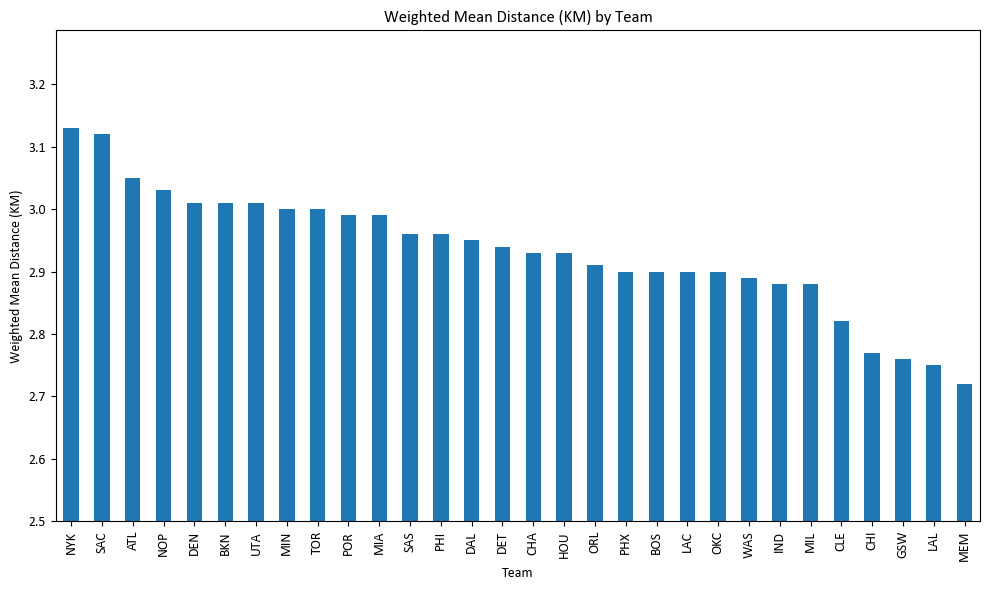

In [42]:
plt.figure(figsize=(10,6))
weighted_dist.plot(kind='bar')

plt.xlabel('Team')
plt.ylabel('Weighted Mean Distance (KM)')
plt.title('Weighted Mean Distance (KM) by Team')
plt.ylim(2.5, None)  # Start y-axis at 2.5
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


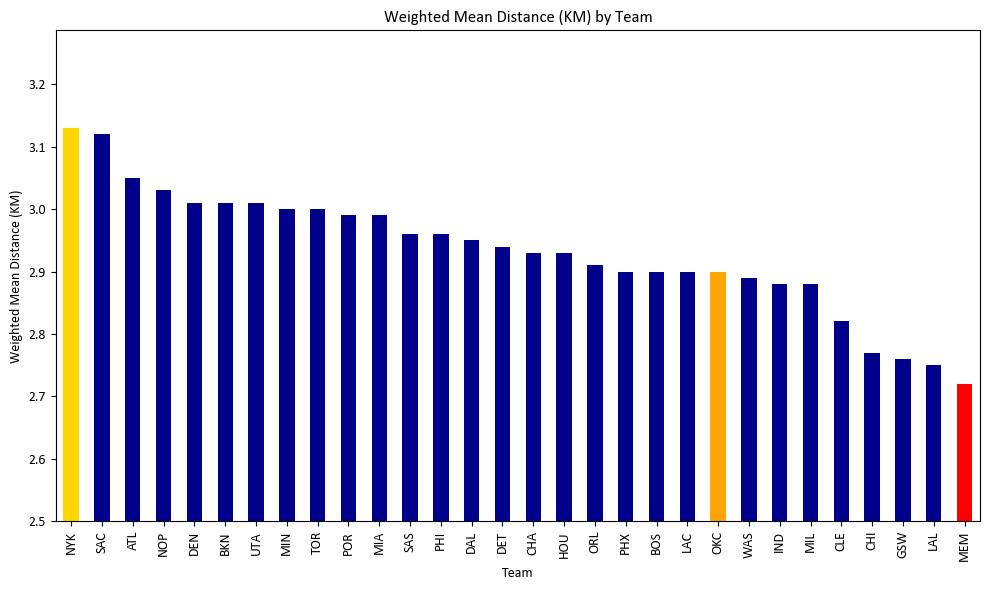

In [43]:
import matplotlib.pyplot as plt

# Sort the Series to determine ranks
sorted_dist = weighted_dist.sort_values(ascending=False)

# Define bar colors
colors = []
for i, team in enumerate(sorted_dist.index):
    if i == 0:
        colors.append('gold')        # Top team
    elif i == 21:
        colors.append('orange')      # 22nd team (index 21)
    elif i == 29:
        colors.append('red')         # 30th team (index 29)
    else:
        colors.append('darkblue')     # Default color

# Plotting
plt.figure(figsize=(10, 6))
sorted_dist.plot(kind='bar', color=colors)

plt.xlabel('Team')
plt.ylabel('Weighted Mean Distance (KM)')
plt.title('Weighted Mean Distance (KM) by Team')
plt.ylim(2.5, None)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


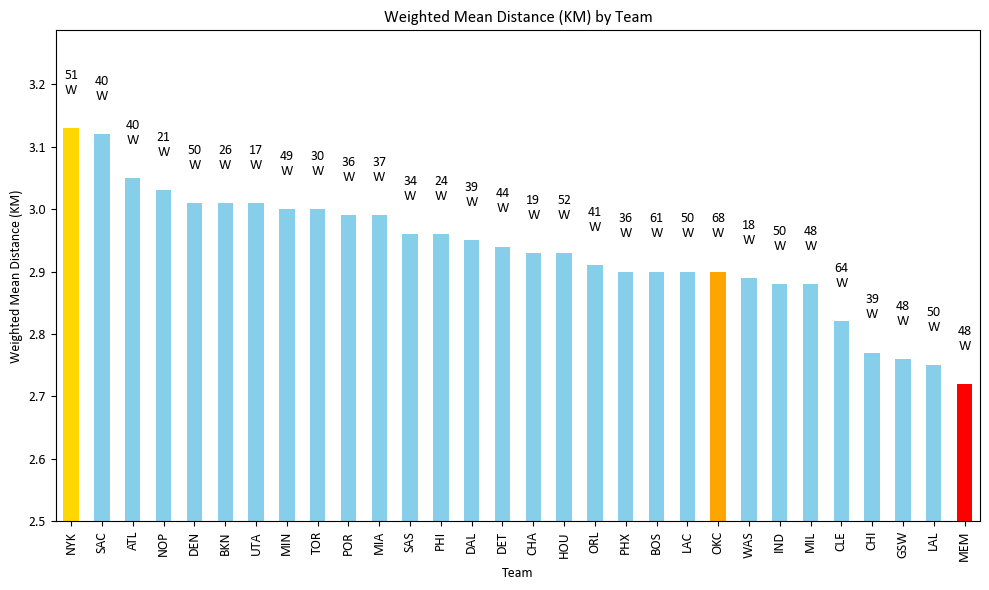

In [44]:
import matplotlib.pyplot as plt

# Sort the Series to determine ranks
sorted_dist = weighted_dist.sort_values(ascending=False)

# Define bar colors
colors = []
for i, team in enumerate(sorted_dist.index):
    if i == 0:
        colors.append('gold')        # Top team
    elif i == 21:
        colors.append('orange')      # 22nd team
    elif i == 29:
        colors.append('red')         # 30th team
    else:
        colors.append('skyblue')     # Default

# Plotting
plt.figure(figsize=(10, 6))
ax = sorted_dist.plot(kind='bar', color=colors)

# Add 'W' labels manually – customize as needed
ax.text(0, sorted_dist.values[0] + 0.05, '51\nW', ha='center', va='bottom')   # 1st bar
ax.text(1, sorted_dist.values[1] + 0.05, '40\nW', ha='center', va='bottom')   # 2nd bar
ax.text(2, sorted_dist.values[2] + 0.05, '40\nW', ha='center', va='bottom')   # 3rd bar
ax.text(3, sorted_dist.values[3] + 0.05, '21\nW', ha='center', va='bottom')   # 4th bar
ax.text(4, sorted_dist.values[4] + 0.05, '50\nW', ha='center', va='bottom')   # 5th bar
ax.text(5, sorted_dist.values[5] + 0.05, '26\nW', ha='center', va='bottom')   # 6th bar
ax.text(6, sorted_dist.values[6] + 0.05, '17\nW', ha='center', va='bottom')   # 7th bar
ax.text(7, sorted_dist.values[7] + 0.05, '49\nW', ha='center', va='bottom')   # 8th bar
ax.text(8, sorted_dist.values[8] + 0.05, '30\nW', ha='center', va='bottom')   # 9th bar
ax.text(9, sorted_dist.values[9] + 0.05, '36\nW', ha='center', va='bottom')   # 10th bar
ax.text(10, sorted_dist.values[10] + 0.05, '37\nW', ha='center', va='bottom') # 11th bar
ax.text(11, sorted_dist.values[11] + 0.05, '34\nW', ha='center', va='bottom') # 12th bar
ax.text(12, sorted_dist.values[12] + 0.05, '24\nW', ha='center', va='bottom') # 13th bar
ax.text(13, sorted_dist.values[13] + 0.05, '39\nW', ha='center', va='bottom') # 14th bar
ax.text(14, sorted_dist.values[14] + 0.05, '44\nW', ha='center', va='bottom') # 15th bar
ax.text(15, sorted_dist.values[15] + 0.05, '19\nW', ha='center', va='bottom') # 16th bar
ax.text(16, sorted_dist.values[16] + 0.05, '52\nW', ha='center', va='bottom') # 17th bar
ax.text(17, sorted_dist.values[17] + 0.05, '41\nW', ha='center', va='bottom') # 18th bar
ax.text(18, sorted_dist.values[18] + 0.05, '36\nW', ha='center', va='bottom') # 19th bar
ax.text(19, sorted_dist.values[19] + 0.05, '61\nW', ha='center', va='bottom') # 20th bar
ax.text(20, sorted_dist.values[20] + 0.05, '50\nW', ha='center', va='bottom') # 21st bar
ax.text(21, sorted_dist.values[21] + 0.05, '68\nW', ha='center', va='bottom') # 22nd bar
ax.text(22, sorted_dist.values[22] + 0.05, '18\nW', ha='center', va='bottom') # 23rd bar
ax.text(23, sorted_dist.values[23] + 0.05, '50\nW', ha='center', va='bottom') # 24th bar
ax.text(24, sorted_dist.values[24] + 0.05, '48\nW', ha='center', va='bottom') # 25th bar
ax.text(25, sorted_dist.values[25] + 0.05, '64\nW', ha='center', va='bottom') # 26th bar
ax.text(26, sorted_dist.values[26] + 0.05, '39\nW', ha='center', va='bottom') # 27th bar
ax.text(27, sorted_dist.values[27] + 0.05, '48\nW', ha='center', va='bottom') # 28th bar
ax.text(28, sorted_dist.values[28] + 0.05, '50\nW', ha='center', va='bottom') # 29th bar
ax.text(29, sorted_dist.values[29] + 0.05, '48\nW', ha='center', va='bottom') # 30th bar

# Labels and formatting
plt.xlabel('Team')
plt.ylabel('Weighted Mean Distance (KM)')
plt.title('Weighted Mean Distance (KM) by Team')
plt.ylim(2.5, None)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [45]:
# Convert weighted_dist Series to DataFrame with 'TEAM' as a column
weighted_dist_df = weighted_dist.reset_index().rename(columns={'index': 'TEAM', 0: 'Weighted Mean Dist (KM)'})

# Merge with nba_standings on 'TEAM'
team_summary = pd.merge(weighted_dist_df, nba_standings[['TEAM', 'PCT']], on='TEAM', how='inner')

# Convert 'PCT' to percentage format
team_summary['PCT'] = (team_summary['PCT'] * 100).round(2)

# Rename columns for clarity
team_summary = team_summary.rename(columns={'PCT': 'Win PCT'})

print(team_summary.head())


  TEAM  Weighted Mean Dist (KM)  Win PCT
0  NYK                     3.13     62.2
1  SAC                     3.12     48.8
2  ATL                     3.05     48.8
3  NOP                     3.03     25.6
4  DEN                     3.01     61.0


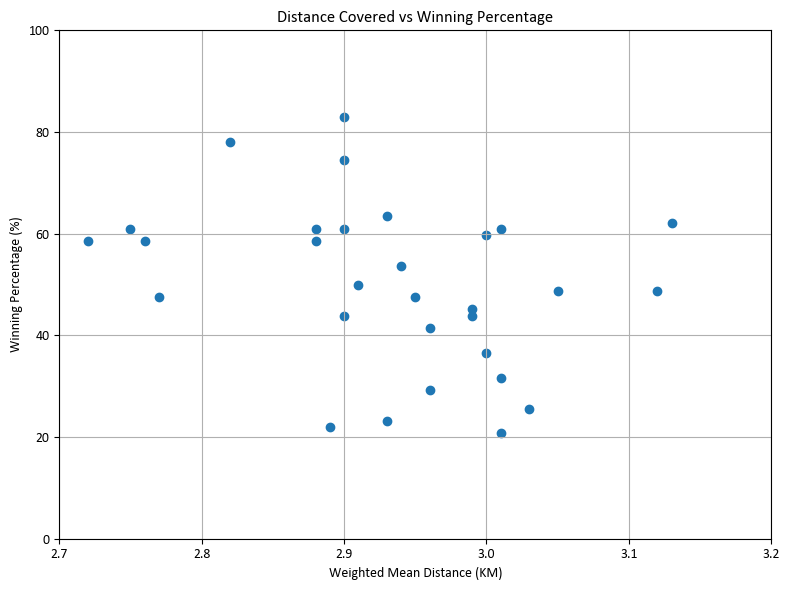

In [46]:
x = team_summary['Weighted Mean Dist (KM)']
y = team_summary['Win PCT']

plt.figure(figsize=(8,6))
plt.scatter(x, y)
plt.xlabel('Weighted Mean Distance (KM)')
plt.ylabel('Winning Percentage (%)')
plt.title('Distance Covered vs Winning Percentage')

# Set axis limits
plt.xlim(2.7, 3.2)
plt.ylim(0, 100)

plt.grid(True)
plt.tight_layout()
plt.show()


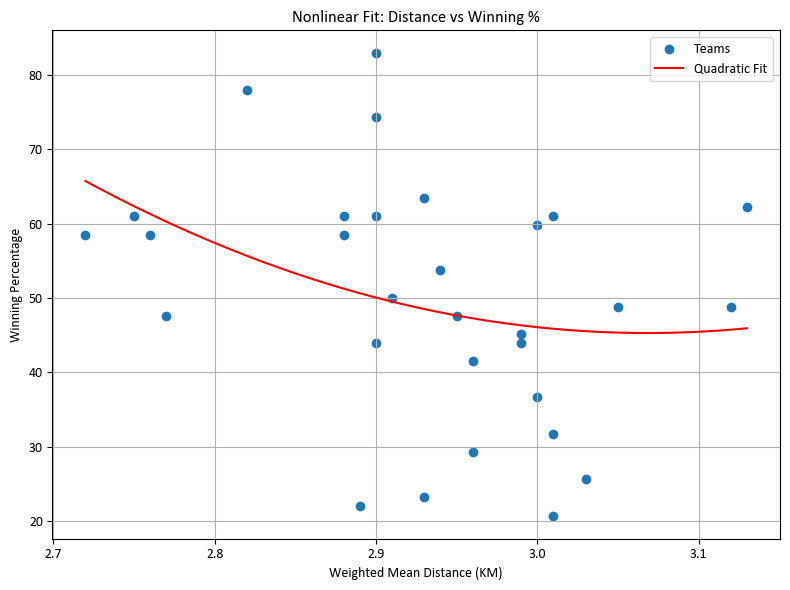

In [47]:
coeffs = np.polyfit(x, y, 2)
poly = np.poly1d(coeffs)

x_fit = np.linspace(x.min(), x.max(), 100)

plt.figure(figsize=(8,6))
plt.scatter(x, y, label='Teams')
plt.plot(x_fit, poly(x_fit), color='red', label='Quadratic Fit')
plt.xlabel('Weighted Mean Distance (KM)')
plt.ylabel('Winning Percentage')
plt.title('Nonlinear Fit: Distance vs Winning %')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [48]:
y_pred = poly(x)
r2 = r2_score(y, y_pred)
print(f"R²: {r2:.3f}")


R²: 0.115


In [49]:
optimal_distance = -coeffs[1] / (2 * coeffs[0])
print(f"Optimal distance (golden line): {optimal_distance:.3f} km")


Optimal distance (golden line): 3.068 km


In [50]:
# Create distance bands
team_summary['Distance Band'] = pd.cut(
    team_summary['Weighted Mean Dist (KM)'],
    bins=[2.7, 2.8, 2.9, 3.0, 3.1, 3.2],
    include_lowest=True
)

# Compute average win % per band
band_win_pct = team_summary.groupby('Distance Band')['Win PCT'].mean().sort_index()

print(band_win_pct)


Distance Band
(2.6990000000000003, 2.8]    56.400000
(2.8, 2.9]                   60.212500
(2.9, 3.0]                   44.918182
(3.0, 3.1]                   37.560000
(3.1, 3.2]                   55.500000
Name: Win PCT, dtype: float64


C:\Users\modri\AppData\Local\Temp\ipykernel_9604\2719663693.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  band_win_pct = team_summary.groupby('Distance Band')['Win PCT'].mean().sort_index()


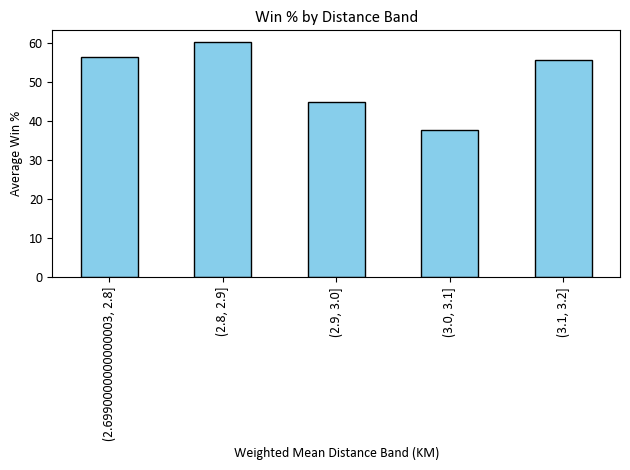

In [51]:
band_win_pct.plot(kind='bar', color='skyblue', edgecolor='black')
plt.ylabel('Average Win %')
plt.xlabel('Weighted Mean Distance Band (KM)')
plt.title('Win % by Distance Band')
plt.tight_layout()
plt.show()

In [52]:
print(team_summary['Distance Band'].value_counts().sort_index())


Distance Band
(2.6990000000000003, 2.8]     4
(2.8, 2.9]                    8
(2.9, 3.0]                   11
(3.0, 3.1]                    5
(3.1, 3.2]                    2
Name: count, dtype: int64


In [53]:
# Prepare win % lists for each band
groups = [
    team_summary.loc[team_summary['Distance Band'] == band, 'Win PCT'].values
    for band in band_win_pct.index
]

# Run ANOVA
f_stat, p_value = f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat:.3f}, p-value: {p_value:.3f}")


ANOVA F-statistic: 2.376, p-value: 0.079


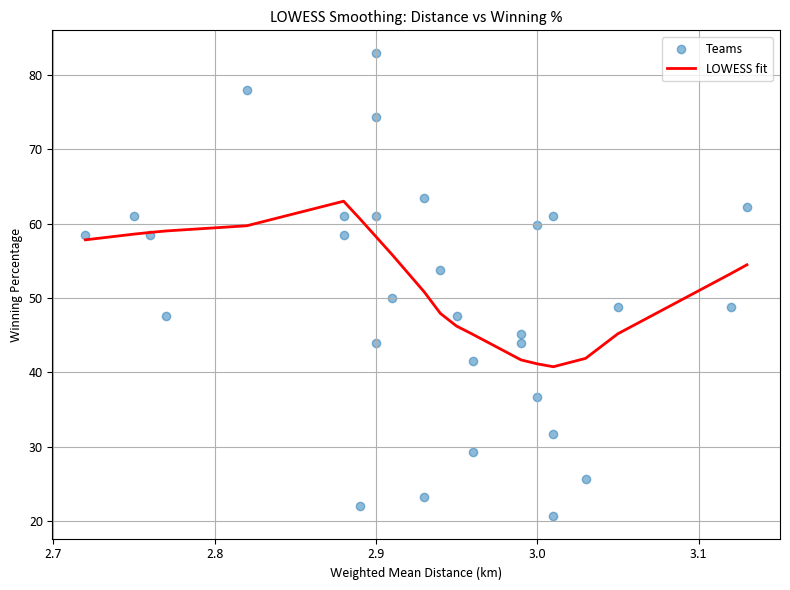

In [54]:
# Apply LOWESS
smoothed = lowess(y, x, frac=0.6)  # You can adjust frac between ~0.3 to 0.8

# Plot
plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.5, label='Teams')
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', linewidth=2, label='LOWESS fit')
plt.xlabel("Weighted Mean Distance (km)")
plt.ylabel("Winning Percentage")
plt.title("LOWESS Smoothing: Distance vs Winning %")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Distance KM Off

In [55]:
team_mean_dist_km_off = nba_df.groupby('TEAM')['Dist. KM Off'].mean().round(2)
team_mean_dist_km_off.sort_values(ascending=False, inplace=True)
team_mean_dist_km_off

TEAM
UTA    1.52
NOP    1.47
BKN    1.46
PHI    1.45
CHA    1.45
ATL    1.39
ORL    1.35
TOR    1.35
DAL    1.34
MIA    1.33
WAS    1.31
PHX    1.31
CLE    1.27
DET    1.26
HOU    1.24
SAS    1.23
BOS    1.23
OKC    1.22
POR    1.21
LAC    1.21
GSW    1.19
MIL    1.19
NYK    1.19
LAL    1.18
DEN    1.18
MEM    1.17
IND    1.12
CHI    1.11
SAC    1.11
MIN    1.02
Name: Dist. KM Off, dtype: float64

In [56]:
# Calculate the weighted distance sum and the total minutes per team
weighted_dist_off = nba_df.groupby('TEAM').apply(
    lambda x: (x['Dist. KM Off'] * x['MIN']).sum() / x['MIN'].sum()
).round(2)


weighted_dist_off = weighted_dist_off.rename('Weighted Mean Dist (KM) Off')
weighted_dist_off = weighted_dist_off.sort_values(ascending=False)
weighted_dist_off

C:\Users\modri\AppData\Local\Temp\ipykernel_9604\1837288757.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_dist_off = nba_df.groupby('TEAM').apply(


TEAM
NYK    1.69
SAC    1.66
UTA    1.63
BKN    1.62
NOP    1.61
ATL    1.61
PHI    1.60
MIN    1.60
MIA    1.60
PHX    1.59
DEN    1.59
CHA    1.58
ORL    1.58
TOR    1.58
HOU    1.57
DAL    1.57
SAS    1.57
POR    1.56
WAS    1.56
BOS    1.55
DET    1.55
LAC    1.55
MIL    1.54
OKC    1.53
IND    1.50
GSW    1.49
CLE    1.49
LAL    1.48
CHI    1.46
MEM    1.43
Name: Weighted Mean Dist (KM) Off, dtype: float64

In [57]:
# Convert weighted_dist Series to DataFrame with 'TEAM' as a column
weighted_dist_df_off = weighted_dist_off.reset_index().rename(columns={'index': 'TEAM', 0: 'Weighted Mean Dist (KM) Off'})

# Merge with nba_standings on 'TEAM'
team_summary_off = pd.merge(weighted_dist_df_off, nba_standings[['TEAM', 'PCT']], on='TEAM', how='inner')

# Convert 'PCT' to percentage format
team_summary_off['PCT'] = (team_summary_off['PCT'] * 100).round(2)

# Rename columns for clarity
team_summary_off = team_summary_off.rename(columns={'PCT': 'Win PCT'})

print(team_summary_off.head())
team_summary_off

  TEAM  Weighted Mean Dist (KM) Off  Win PCT
0  NYK                         1.69     62.2
1  SAC                         1.66     48.8
2  UTA                         1.63     20.7
3  BKN                         1.62     31.7
4  NOP                         1.61     25.6


,TEAM,Weighted Mean Dist (KM) Off,Win PCT
0,NYK,1.69,62.2
1,SAC,1.66,48.8
2,UTA,1.63,20.7
3,BKN,1.62,31.7
4,NOP,1.61,25.6
5,ATL,1.61,48.8
6,PHI,1.60,29.3
7,MIN,1.60,59.8
8,MIA,1.60,45.1
9,PHX,1.59,43.9


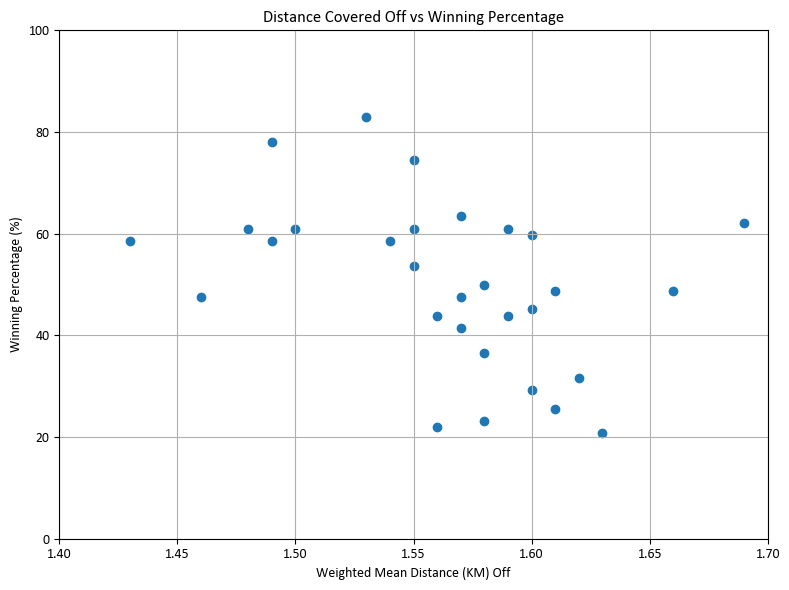

In [58]:
x = team_summary_off['Weighted Mean Dist (KM) Off']
y = team_summary_off['Win PCT']

plt.figure(figsize=(8,6))
plt.scatter(x, y)
plt.xlabel('Weighted Mean Distance (KM) Off')
plt.ylabel('Winning Percentage (%)')
plt.title('Distance Covered Off vs Winning Percentage')

# Set axis limits
plt.xlim(1.4, 1.7)
plt.ylim(0, 100)

plt.grid(True)
plt.tight_layout()
plt.show()


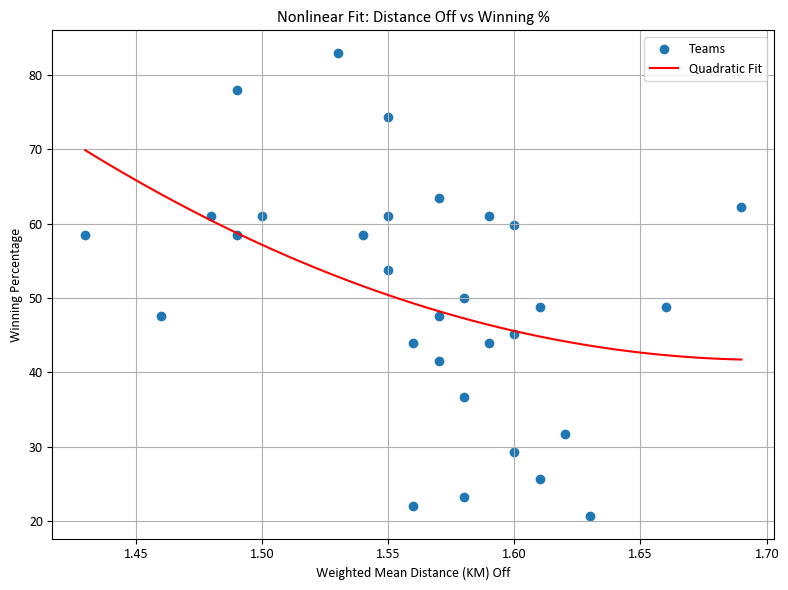

In [59]:
coeffs_off = np.polyfit(x, y, 2)
poly = np.poly1d(coeffs_off)

x_fit = np.linspace(x.min(), x.max(), 100)

plt.figure(figsize=(8,6))
plt.scatter(x, y, label='Teams')
plt.plot(x_fit, poly(x_fit), color='red', label='Quadratic Fit')
plt.xlabel('Weighted Mean Distance (KM) Off')
plt.ylabel('Winning Percentage')
plt.title('Nonlinear Fit: Distance Off vs Winning %')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [60]:
y_pred = poly(x)
r2 = r2_score(y, y_pred)
print(f"R²: {r2:.3f}")


R²: 0.168


In [61]:
optimal_distance_off = -coeffs_off[1] / (2 * coeffs_off[0])
print(f"Optimal distance (golden line): {optimal_distance_off:.3f} km")


Optimal distance (golden line): 1.700 km


In [62]:
# Create distance bands
team_summary_off['Distance Band'] = pd.cut(
    team_summary_off['Weighted Mean Dist (KM) Off'],
    bins=[1.4, 1.5, 1.6, 1.7],
    include_lowest=True
)

# Compute average win % per band
band_win_pct_off = team_summary_off.groupby('Distance Band')['Win PCT'].mean().sort_index()

print(band_win_pct_off)


Distance Band
(1.399, 1.5]    60.766667
(1.5, 1.6]      49.877778
(1.6, 1.7]      39.633333
Name: Win PCT, dtype: float64


C:\Users\modri\AppData\Local\Temp\ipykernel_9604\2485165788.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  band_win_pct_off = team_summary_off.groupby('Distance Band')['Win PCT'].mean().sort_index()


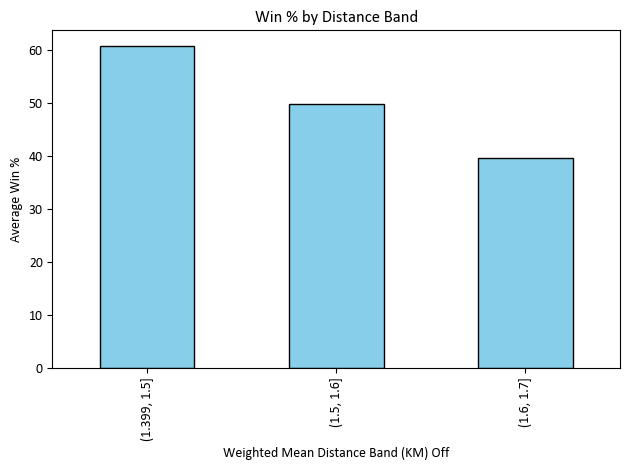

In [63]:
band_win_pct_off.plot(kind='bar', color='skyblue', edgecolor='black')
plt.ylabel('Average Win %')
plt.xlabel('Weighted Mean Distance Band (KM) Off')
plt.title('Win % by Distance Band')
plt.tight_layout()
plt.show()

In [64]:
print(team_summary_off['Distance Band'].value_counts().sort_index())


Distance Band
(1.399, 1.5]     6
(1.5, 1.6]      18
(1.6, 1.7]       6
Name: count, dtype: int64


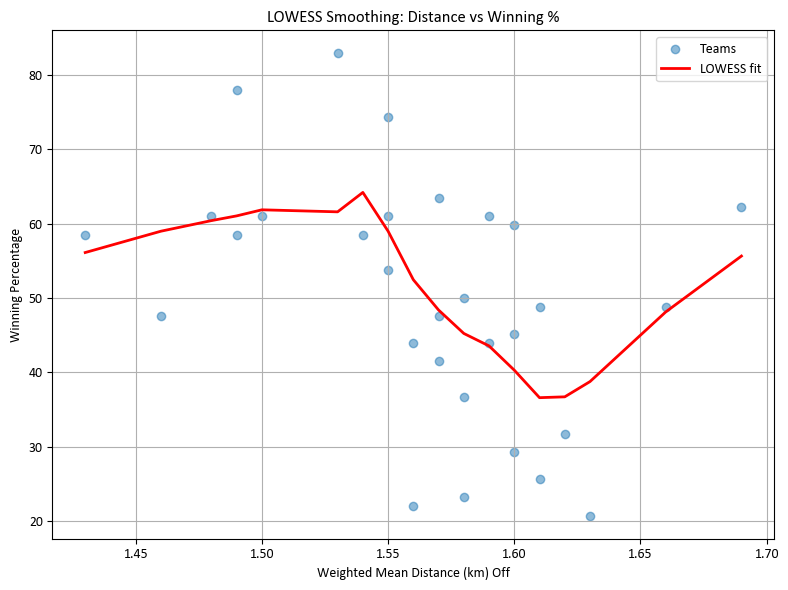

In [65]:
# Apply LOWESS
smoothed = lowess(y, x, frac=0.6)  # You can adjust frac between ~0.3 to 0.8

# Plot
plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.5, label='Teams')
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', linewidth=2, label='LOWESS fit')
plt.xlabel("Weighted Mean Distance (km) Off")
plt.ylabel("Winning Percentage")
plt.title("LOWESS Smoothing: Distance vs Winning %")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Distance KM Def

In [66]:
team_mean_dist_km_def = nba_df.groupby('TEAM')['Dist. KM Def'].mean().round(2)
team_mean_dist_km_def.sort_values(ascending=False, inplace=True)
team_mean_dist_km_def

TEAM
UTA    1.30
NOP    1.30
BKN    1.26
PHI    1.24
CHA    1.24
ATL    1.24
TOR    1.23
DAL    1.17
MIA    1.15
ORL    1.15
DET    1.14
WAS    1.13
CLE    1.13
POR    1.12
SAS    1.10
OKC    1.09
HOU    1.09
PHX    1.08
BOS    1.07
MEM    1.06
DEN    1.05
LAC    1.05
MIL    1.04
IND    1.04
LAL    1.02
GSW    1.01
NYK    1.01
CHI    1.00
SAC    0.98
MIN    0.90
Name: Dist. KM Def, dtype: float64

In [67]:
# Calculate the weighted distance sum and the total minutes per team
weighted_dist_def = nba_df.groupby('TEAM').apply(
    lambda x: (x['Dist. KM Def'] * x['MIN']).sum() / x['MIN'].sum()
).round(2)


weighted_dist_def = weighted_dist_def.rename('Weighted Mean Dist (KM) Def')
weighted_dist_def = weighted_dist_def.sort_values(ascending=False)
weighted_dist_def

C:\Users\modri\AppData\Local\Temp\ipykernel_9604\3168783422.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_dist_def = nba_df.groupby('TEAM').apply(


TEAM
SAC    1.46
ATL    1.43
TOR    1.43
POR    1.43
NYK    1.43
DEN    1.42
NOP    1.41
MIN    1.40
MIA    1.39
SAS    1.39
DET    1.39
BKN    1.39
IND    1.38
UTA    1.38
DAL    1.37
HOU    1.37
OKC    1.36
PHI    1.36
BOS    1.35
CHA    1.35
LAC    1.35
MIL    1.34
ORL    1.34
WAS    1.33
CLE    1.33
CHI    1.31
PHX    1.31
MEM    1.30
LAL    1.27
GSW    1.27
Name: Weighted Mean Dist (KM) Def, dtype: float64

In [68]:
# Convert weighted_dist Series to DataFrame with 'TEAM' as a column
weighted_dist_df_def = weighted_dist_def.reset_index().rename(columns={'index': 'TEAM', 0: 'Weighted Mean Dist (KM) Def'})

# Merge with nba_standings on 'TEAM'
team_summary_def = pd.merge(weighted_dist_df_def, nba_standings[['TEAM', 'PCT']], on='TEAM', how='inner')

# Convert 'PCT' to percentage format
team_summary_def['PCT'] = (team_summary_def['PCT'] * 100).round(2)

# Rename columns for clarity
team_summary_def = team_summary_def.rename(columns={'PCT': 'Win PCT'})

print(team_summary_def.head())
team_summary_def

  TEAM  Weighted Mean Dist (KM) Def  Win PCT
0  SAC                         1.46     48.8
1  ATL                         1.43     48.8
2  TOR                         1.43     36.6
3  POR                         1.43     43.9
4  NYK                         1.43     62.2


,TEAM,Weighted Mean Dist (KM) Def,Win PCT
0,SAC,1.46,48.8
1,ATL,1.43,48.8
2,TOR,1.43,36.6
3,POR,1.43,43.9
4,NYK,1.43,62.2
5,DEN,1.42,61.0
6,NOP,1.41,25.6
7,MIN,1.40,59.8
8,MIA,1.39,45.1
9,SAS,1.39,41.5


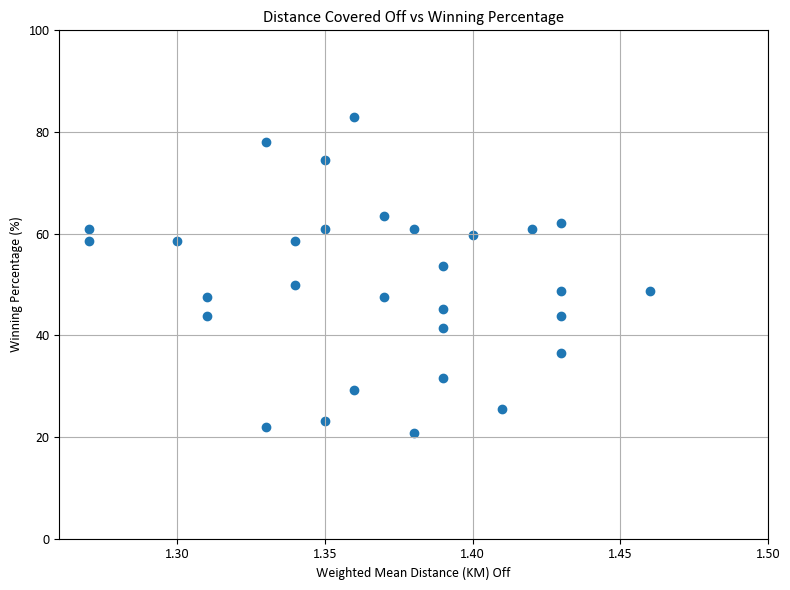

In [69]:
x = team_summary_def['Weighted Mean Dist (KM) Def']
y = team_summary_def['Win PCT']

plt.figure(figsize=(8,6))
plt.scatter(x, y)
plt.xlabel('Weighted Mean Distance (KM) Off')
plt.ylabel('Winning Percentage (%)')
plt.title('Distance Covered Off vs Winning Percentage')

# Set axis limits
plt.xlim(1.26, 1.5)
plt.ylim(0, 100)

plt.grid(True)
plt.tight_layout()
plt.show()


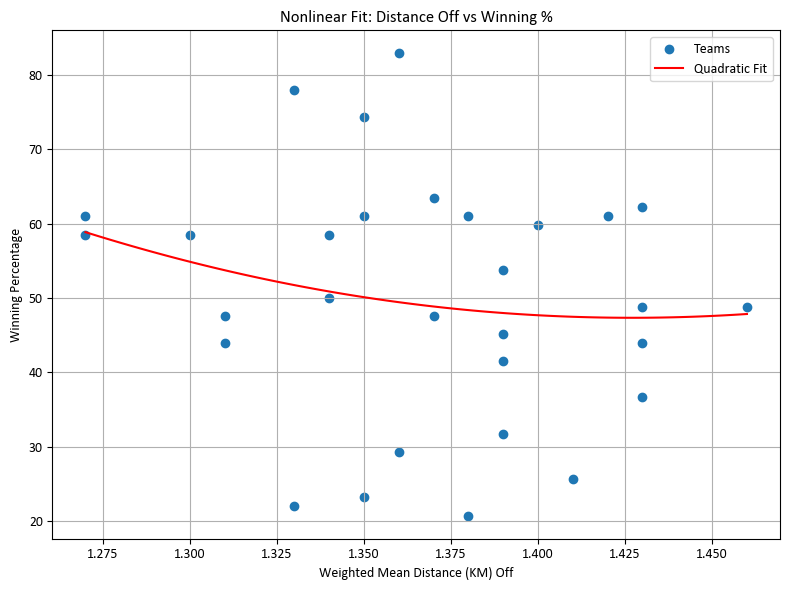

In [70]:
coeffs_def = np.polyfit(x, y, 2)
poly = np.poly1d(coeffs_def)

x_fit = np.linspace(x.min(), x.max(), 100)

plt.figure(figsize=(8,6))
plt.scatter(x, y, label='Teams')
plt.plot(x_fit, poly(x_fit), color='red', label='Quadratic Fit')
plt.xlabel('Weighted Mean Distance (KM) Off')
plt.ylabel('Winning Percentage')
plt.title('Nonlinear Fit: Distance Off vs Winning %')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [71]:
y_pred = poly(x)
r2 = r2_score(y, y_pred)
print(f"R²: {r2:.3f}")


R²: 0.038


In [72]:
optimal_distance_def = -coeffs_def[1] / (2 * coeffs_def[0])
print(f"Optimal distance (golden line): {optimal_distance_def:.3f} km")


Optimal distance (golden line): 1.427 km


In [73]:
# Create distance bands
team_summary_def['Distance Band'] = pd.cut(
    team_summary_def['Weighted Mean Dist (KM) Def'],
    bins=[1.25, 1.3, 1.35, 1.40, 1.45, 1.5],
    include_lowest=True
)

# Compute average win % per band
band_win_pct_def = team_summary_def.groupby('Distance Band')['Win PCT'].mean().sort_index()

print(band_win_pct_def)


Distance Band
(1.249, 1.3]    59.333333
(1.3, 1.35]     50.955556
(1.35, 1.4]     48.790909
(1.4, 1.45]     46.350000
(1.45, 1.5]     48.800000
Name: Win PCT, dtype: float64


C:\Users\modri\AppData\Local\Temp\ipykernel_9604\3274605105.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  band_win_pct_def = team_summary_def.groupby('Distance Band')['Win PCT'].mean().sort_index()


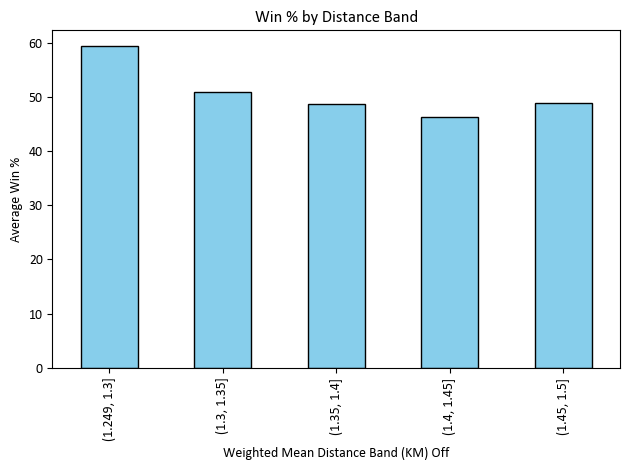

In [74]:
band_win_pct_def.plot(kind='bar', color='skyblue', edgecolor='black')
plt.ylabel('Average Win %')
plt.xlabel('Weighted Mean Distance Band (KM) Off')
plt.title('Win % by Distance Band')
plt.tight_layout()
plt.show()

In [75]:
print(team_summary_def['Distance Band'].value_counts().sort_index())


Distance Band
(1.249, 1.3]     3
(1.3, 1.35]      9
(1.35, 1.4]     11
(1.4, 1.45]      6
(1.45, 1.5]      1
Name: count, dtype: int64


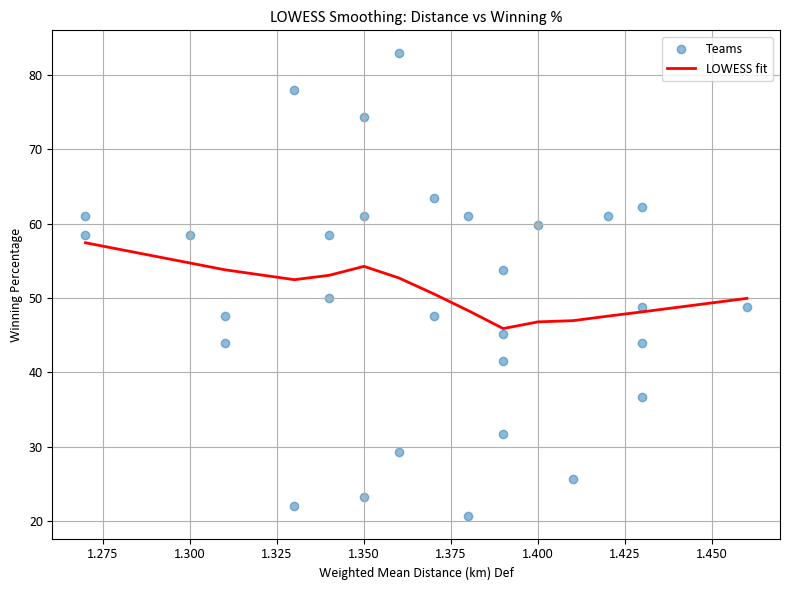

In [76]:
# Apply LOWESS
smoothed = lowess(y, x, frac=0.6)  # You can adjust frac between ~0.3 to 0.8

# Plot
plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.5, label='Teams')
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', linewidth=2, label='LOWESS fit')
plt.xlabel("Weighted Mean Distance (km) Def")
plt.ylabel("Winning Percentage")
plt.title("LOWESS Smoothing: Distance vs Winning %")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Average Speed

In [77]:
team_mean_avg_kmh = nba_df.groupby('TEAM')['Avg Speed (km/h)'].mean().round(2)
team_mean_avg_kmh.sort_values(ascending=False, inplace=True)
team_mean_avg_kmh

TEAM
IND    7.19
MEM    7.16
TOR    7.13
ATL    7.11
GSW    7.11
CHI    7.03
BKN    7.00
NOP    6.98
CLE    6.98
OKC    6.95
DAL    6.93
PHX    6.93
WAS    6.93
POR    6.92
SAS    6.91
MIA    6.91
CHA    6.91
UTA    6.90
MIN    6.88
DET    6.88
SAC    6.86
MIL    6.86
ORL    6.85
NYK    6.84
HOU    6.81
PHI    6.78
LAC    6.76
LAL    6.74
DEN    6.70
BOS    6.63
Name: Avg Speed (km/h), dtype: float64

In [78]:
# Calculate the weighted distance sum and the total minutes per team
weighted_avg_kmh = nba_df.groupby('TEAM').apply(
    lambda x: (x['Avg Speed (km/h)'] * x['MIN']).sum() / x['MIN'].sum()
).round(2)


weighted_avg_kmh = weighted_avg_kmh.rename('Weighted Mean Speed (km/h)')
weighted_avg_kmh = weighted_avg_kmh.sort_values(ascending=False)
weighted_avg_kmh

C:\Users\modri\AppData\Local\Temp\ipykernel_9604\1893089718.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_avg_kmh = nba_df.groupby('TEAM').apply(


TEAM
MEM    7.13
IND    7.12
TOR    7.11
ATL    7.06
GSW    7.03
BKN    7.00
CHI    7.00
WAS    7.00
NOP    6.97
CLE    6.95
MIA    6.92
OKC    6.92
CHA    6.90
UTA    6.89
SAC    6.89
POR    6.87
DET    6.87
SAS    6.85
PHX    6.82
ORL    6.82
DAL    6.80
MIN    6.79
MIL    6.78
PHI    6.75
HOU    6.74
NYK    6.72
LAC    6.63
LAL    6.63
DEN    6.62
BOS    6.54
Name: Weighted Mean Speed (km/h), dtype: float64

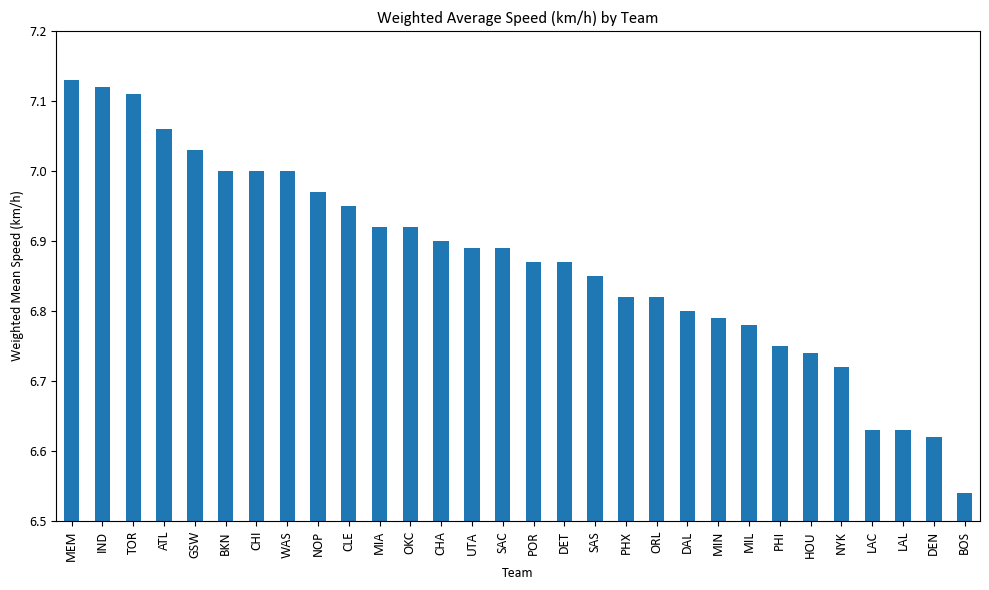

In [79]:
plt.figure(figsize=(10,6))
weighted_avg_kmh.plot(kind='bar')

plt.xlabel('Team')
plt.ylabel('Weighted Mean Speed (km/h)')
plt.title('Weighted Average Speed (km/h) by Team')
plt.ylim(6.5, 7.2)  
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


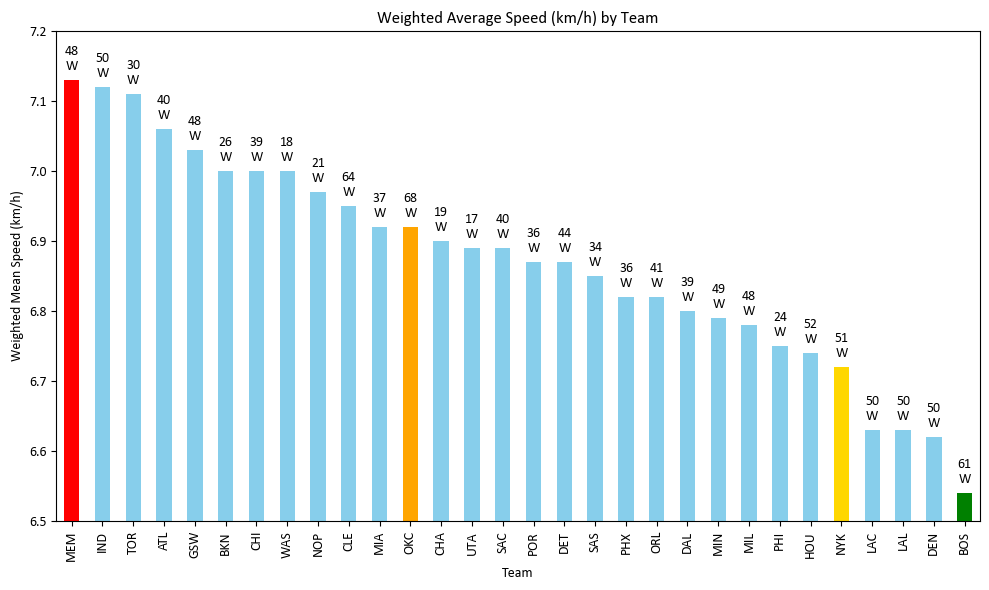

In [80]:
# Sort the Series for consistent ranking (optional)
sorted_speed = weighted_avg_kmh.sort_values(ascending=False)

# Define colors if you'd like (optional – you can skip this part)
colors = ['skyblue'] * len(sorted_speed)
colors[0] = 'red'      # Top team
colors[11] = 'orange'   # 22nd
colors[29] = 'green'      # 30th
colors[25] = 'gold'      # 25th

# Plot
plt.figure(figsize=(10, 6))
ax = sorted_speed.plot(kind='bar', color=colors)

# Add stacked "value\nW" labels manually
ax.text(0, sorted_speed.values[0] + 0.01, '48\nW', ha='center', va='bottom')
ax.text(1, sorted_speed.values[1] + 0.01, '50\nW', ha='center', va='bottom')
ax.text(2, sorted_speed.values[2] + 0.01, '30\nW', ha='center', va='bottom')
ax.text(3, sorted_speed.values[3] + 0.01, '40\nW', ha='center', va='bottom')
ax.text(4, sorted_speed.values[4] + 0.01, '48\nW', ha='center', va='bottom')
ax.text(5, sorted_speed.values[5] + 0.01, '26\nW', ha='center', va='bottom')
ax.text(6, sorted_speed.values[6] + 0.01, '39\nW', ha='center', va='bottom')
ax.text(7, sorted_speed.values[7] + 0.01, '18\nW', ha='center', va='bottom')
ax.text(8, sorted_speed.values[8] + 0.01, '21\nW', ha='center', va='bottom')
ax.text(9, sorted_speed.values[9] + 0.01, '64\nW', ha='center', va='bottom')
ax.text(10, sorted_speed.values[10] + 0.01, '37\nW', ha='center', va='bottom')
ax.text(11, sorted_speed.values[11] + 0.01, '68\nW', ha='center', va='bottom')
ax.text(12, sorted_speed.values[12] + 0.01, '19\nW', ha='center', va='bottom')
ax.text(13, sorted_speed.values[13] + 0.01, '17\nW', ha='center', va='bottom')
ax.text(14, sorted_speed.values[14] + 0.01, '40\nW', ha='center', va='bottom')
ax.text(15, sorted_speed.values[15] + 0.01, '36\nW', ha='center', va='bottom')
ax.text(16, sorted_speed.values[16] + 0.01, '44\nW', ha='center', va='bottom')
ax.text(17, sorted_speed.values[17] + 0.01, '34\nW', ha='center', va='bottom')
ax.text(18, sorted_speed.values[18] + 0.01, '36\nW', ha='center', va='bottom')
ax.text(19, sorted_speed.values[19] + 0.01, '41\nW', ha='center', va='bottom')
ax.text(20, sorted_speed.values[20] + 0.01, '39\nW', ha='center', va='bottom')
ax.text(21, sorted_speed.values[21] + 0.01, '49\nW', ha='center', va='bottom')
ax.text(22, sorted_speed.values[22] + 0.01, '48\nW', ha='center', va='bottom')
ax.text(23, sorted_speed.values[23] + 0.01, '24\nW', ha='center', va='bottom')
ax.text(24, sorted_speed.values[24] + 0.01, '52\nW', ha='center', va='bottom')
ax.text(25, sorted_speed.values[25] + 0.01, '51\nW', ha='center', va='bottom')
ax.text(26, sorted_speed.values[26] + 0.01, '50\nW', ha='center', va='bottom')
ax.text(27, sorted_speed.values[27] + 0.01, '50\nW', ha='center', va='bottom')
ax.text(28, sorted_speed.values[28] + 0.01, '50\nW', ha='center', va='bottom')
ax.text(29, sorted_speed.values[29] + 0.01, '61\nW', ha='center', va='bottom')

# Labels and formatting
plt.xlabel('Team')
plt.ylabel('Weighted Mean Speed (km/h)')
plt.title('Weighted Average Speed (km/h) by Team')
plt.ylim(6.5, 7.2)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [81]:
# Convert  Series to DataFrame with 'TEAM' as a column
weighted_avg_kmh_df = weighted_avg_kmh.reset_index().rename(columns={'index': 'TEAM', 0: 'Weighted Mean Speed (km/h)'})

# Merge with nba_standings on 'TEAM'
team_summary_kmh = pd.merge(weighted_avg_kmh_df, nba_standings[['TEAM', 'PCT']], on='TEAM', how='inner')

# Convert 'PCT' to percentage format
team_summary_kmh['PCT'] = (team_summary_kmh['PCT'] * 100).round(2)

# Rename columns for clarity
team_summary_kmh = team_summary_kmh.rename(columns={'PCT': 'Win PCT'})

print(team_summary_kmh.head())


  TEAM  Weighted Mean Speed (km/h)  Win PCT
0  MEM                        7.13     58.5
1  IND                        7.12     61.0
2  TOR                        7.11     36.6
3  ATL                        7.06     48.8
4  GSW                        7.03     58.5


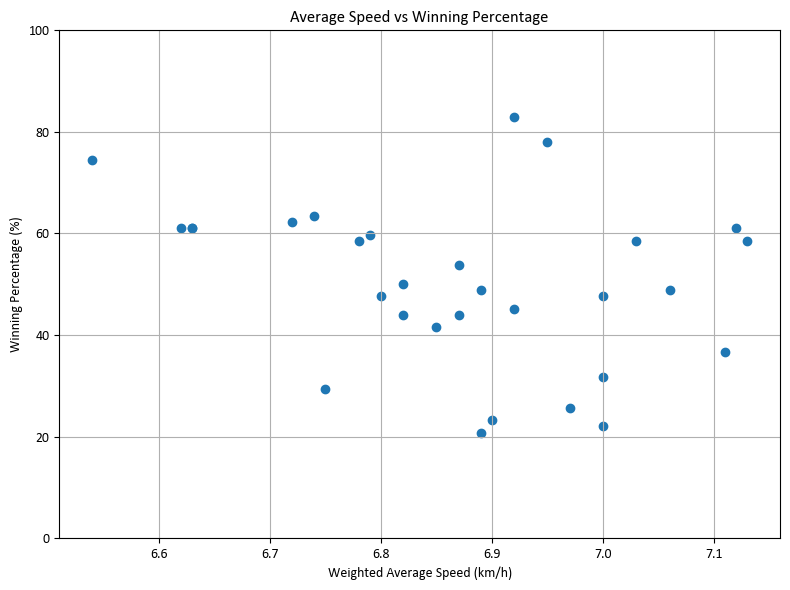

In [82]:
x = team_summary_kmh['Weighted Mean Speed (km/h)']
y = team_summary_kmh['Win PCT']

plt.figure(figsize=(8,6))
plt.scatter(x, y)
plt.xlabel('Weighted Average Speed (km/h)')
plt.ylabel('Winning Percentage (%)')
plt.title('Average Speed vs Winning Percentage')

# Set axis limits
plt.xlim(None, None)
plt.ylim(0, 100)

plt.grid(True)
plt.tight_layout()
plt.show()


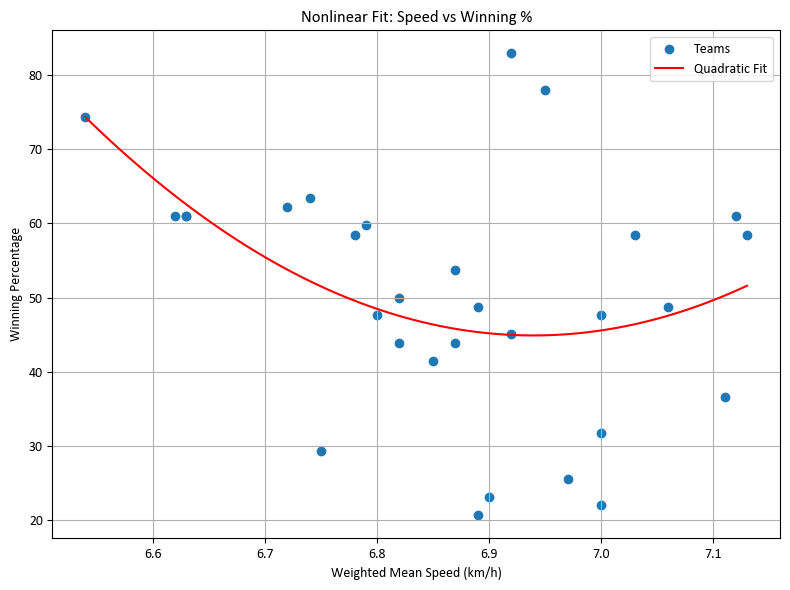

In [83]:
coeffs_kmh = np.polyfit(x, y, 2)
poly = np.poly1d(coeffs_kmh)

x_fit = np.linspace(x.min(), x.max(), 100)

plt.figure(figsize=(8,6))
plt.scatter(x, y, label='Teams')
plt.plot(x_fit, poly(x_fit), color='red', label='Quadratic Fit')
plt.xlabel('Weighted Mean Speed (km/h)')
plt.ylabel('Winning Percentage')
plt.title('Nonlinear Fit: Speed vs Winning %')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [84]:
y_pred = poly(x)
r2 = r2_score(y, y_pred)
print(f"R²: {r2:.3f}")


R²: 0.186


In [85]:
optimal_speed = -coeffs_kmh[1] / (2 * coeffs_kmh[0])
print(f"Optimal distance (golden line): {optimal_speed:.3f} km")

Optimal distance (golden line): 6.939 km


In [86]:
# Create distance bands
team_summary_kmh['Distance Band'] = pd.cut(
    team_summary_kmh['Weighted Mean Speed (km/h)'],
    bins=[6.5, 6.7, 6.9, 7.1, 7.3],
    include_lowest=True
)

# Compute average win % per band
band_win_pct_kmh = team_summary_kmh.groupby('Distance Band')['Win PCT'].mean().sort_index()

print(band_win_pct_kmh)


Distance Band
(6.499, 6.7]    64.350000
(6.7, 6.9]      46.178571
(6.9, 7.1]      48.911111
(7.1, 7.3]      52.033333
Name: Win PCT, dtype: float64


C:\Users\modri\AppData\Local\Temp\ipykernel_9604\1167211338.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  band_win_pct_kmh = team_summary_kmh.groupby('Distance Band')['Win PCT'].mean().sort_index()


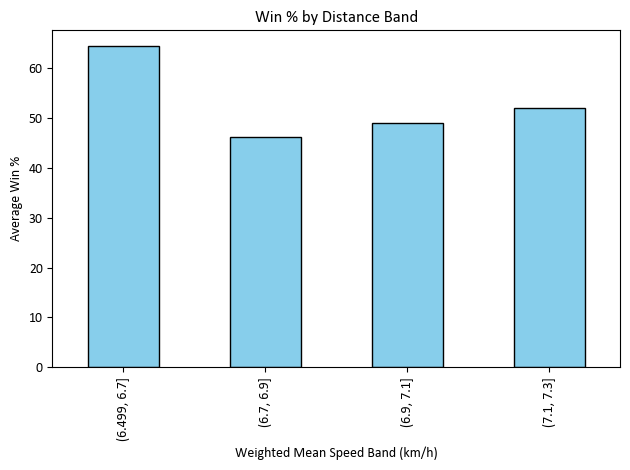

In [87]:
band_win_pct_kmh.plot(kind='bar', color='skyblue', edgecolor='black')
plt.ylabel('Average Win %')
plt.xlabel('Weighted Mean Speed Band (km/h)')
plt.title('Win % by Distance Band')
plt.tight_layout()
plt.show()

In [88]:
print(team_summary_kmh['Distance Band'].value_counts().sort_index())


Distance Band
(6.499, 6.7]     4
(6.7, 6.9]      14
(6.9, 7.1]       9
(7.1, 7.3]       3
Name: count, dtype: int64


In [89]:
# Prepare win % lists for each band
groups_kmh = [
    team_summary_kmh.loc[team_summary_kmh['Distance Band'] == band, 'Win PCT'].values
    for band in band_win_pct_kmh.index
]

# Run ANOVA
f_stat, p_value = f_oneway(*groups_kmh)
print(f"ANOVA F-statistic: {f_stat:.3f}, p-value: {p_value:.3f}")


ANOVA F-statistic: 1.373, p-value: 0.273


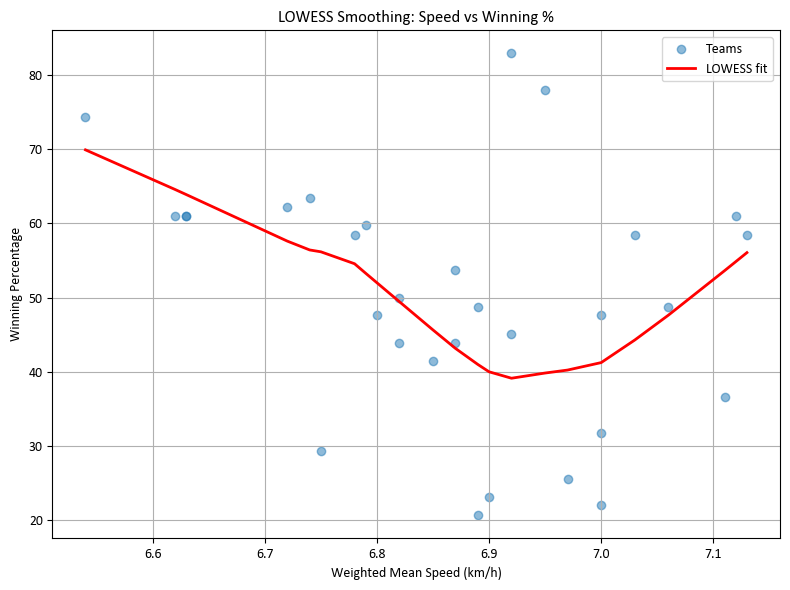

In [90]:
# Apply LOWESS
smoothed = lowess(y, x, frac=0.6)  

# Plot
plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.5, label='Teams')
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', linewidth=2, label='LOWESS fit')
plt.xlabel("Weighted Mean Speed (km/h)")
plt.ylabel("Winning Percentage")
plt.title("LOWESS Smoothing: Speed vs Winning %")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Average Speed km/h Off

In [91]:
team_mean_avg_kmh_off = nba_df.groupby('TEAM')['Avg Speed (km/h) Off'].mean().round(2)
team_mean_avg_kmh_off.sort_values(ascending=False, inplace=True)
team_mean_avg_kmh_off

TEAM
ATL    7.81
CHI    7.77
IND    7.67
MEM    7.67
TOR    7.59
GSW    7.58
SAS    7.54
WAS    7.53
CLE    7.51
BKN    7.44
OKC    7.43
NOP    7.39
DAL    7.36
PHX    7.35
SAC    7.32
MIA    7.32
CHA    7.30
MIL    7.29
PHI    7.24
POR    7.23
ORL    7.22
DET    7.21
NYK    7.21
MIN    7.19
HOU    7.18
UTA    7.18
DEN    7.17
LAC    7.12
LAL    7.04
BOS    6.88
Name: Avg Speed (km/h) Off, dtype: float64

In [92]:
# Calculate the weighted speed sum and the total minutes per team
weighted_avg_kmh_off = nba_df.groupby('TEAM').apply(
    lambda x: (x['Avg Speed (km/h) Off'] * x['MIN']).sum() / x['MIN'].sum()
).round(2)


weighted_avg_kmh_off = weighted_avg_kmh_off.rename('Weighted Mean Speed (km/h) Off')
weighted_avg_kmh_off = weighted_avg_kmh_off.sort_values(ascending=False)
weighted_avg_kmh_off

C:\Users\modri\AppData\Local\Temp\ipykernel_9604\2544611162.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_avg_kmh_off = nba_df.groupby('TEAM').apply(


TEAM
ATL    7.76
CHI    7.71
MEM    7.64
IND    7.61
TOR    7.59
WAS    7.58
CLE    7.56
GSW    7.55
OKC    7.48
NOP    7.40
SAS    7.40
BKN    7.40
MIA    7.37
SAC    7.36
CHA    7.31
DET    7.25
DAL    7.25
PHX    7.24
MIL    7.22
POR    7.21
PHI    7.20
ORL    7.20
UTA    7.20
MIN    7.18
DEN    7.12
HOU    7.10
NYK    7.04
LAC    6.99
LAL    6.94
BOS    6.80
Name: Weighted Mean Speed (km/h) Off, dtype: float64

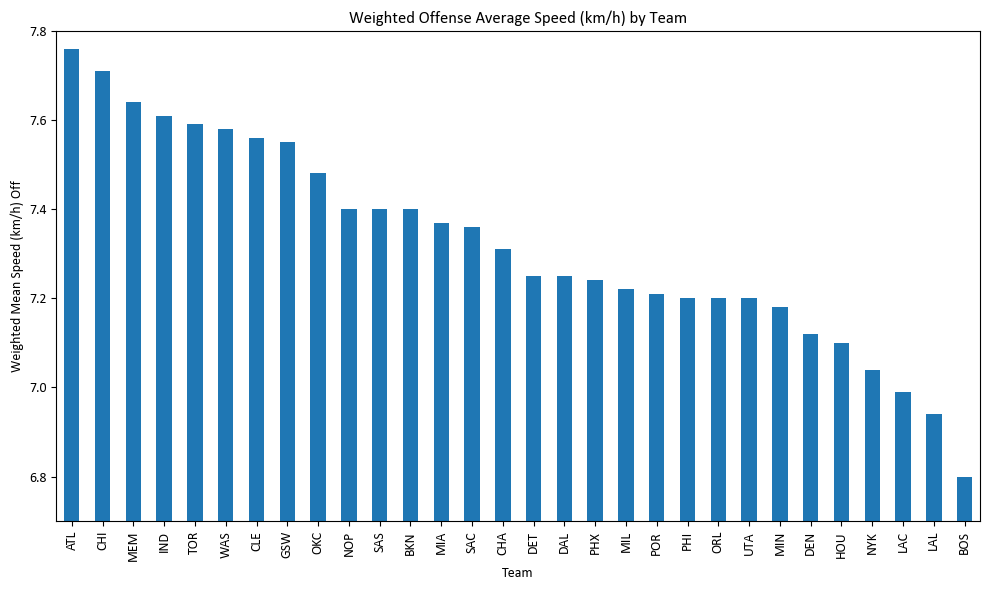

In [93]:
plt.figure(figsize=(10,6))
weighted_avg_kmh_off.plot(kind='bar')

plt.xlabel('Team')
plt.ylabel('Weighted Mean Speed (km/h) Off')
plt.title('Weighted Offense Average Speed (km/h) by Team')
plt.ylim(6.7, 7.8)  
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [94]:
# Convert  Series to DataFrame with 'TEAM' as a column
weighted_avg_kmh_df_off = weighted_avg_kmh_off.reset_index().rename(columns={'index': 'TEAM', 0: 'Weighted Mean Speed (km/h) Off'})

# Merge with nba_standings on 'TEAM'
team_summary_kmh_off = pd.merge(weighted_avg_kmh_df_off, nba_standings[['TEAM', 'PCT']], on='TEAM', how='inner')

# Convert 'PCT' to percentage format
team_summary_kmh_off['PCT'] = (team_summary_kmh_off['PCT'] * 100).round(2)

# Rename columns for clarity
team_summary_kmh_off = team_summary_kmh_off.rename(columns={'PCT': 'Win PCT'})

print(team_summary_kmh_off.head())


  TEAM  Weighted Mean Speed (km/h) Off  Win PCT
0  ATL                            7.76     48.8
1  CHI                            7.71     47.6
2  MEM                            7.64     58.5
3  IND                            7.61     61.0
4  TOR                            7.59     36.6


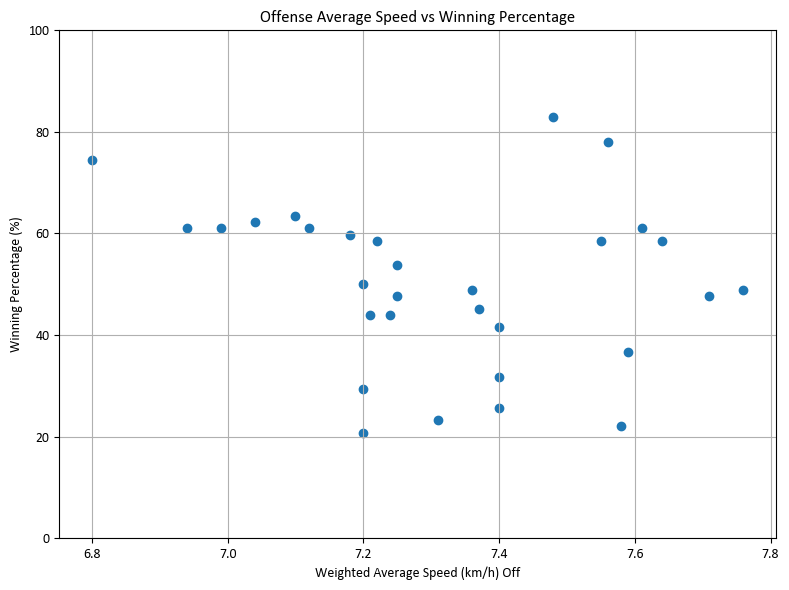

In [95]:
x = team_summary_kmh_off['Weighted Mean Speed (km/h) Off']
y = team_summary_kmh_off['Win PCT']

plt.figure(figsize=(8,6))
plt.scatter(x, y)
plt.xlabel('Weighted Average Speed (km/h) Off')
plt.ylabel('Winning Percentage (%)')
plt.title('Offense Average Speed vs Winning Percentage')

# Set axis limits
plt.xlim(None, None)
plt.ylim(0, 100)

plt.grid(True)
plt.tight_layout()
plt.show()


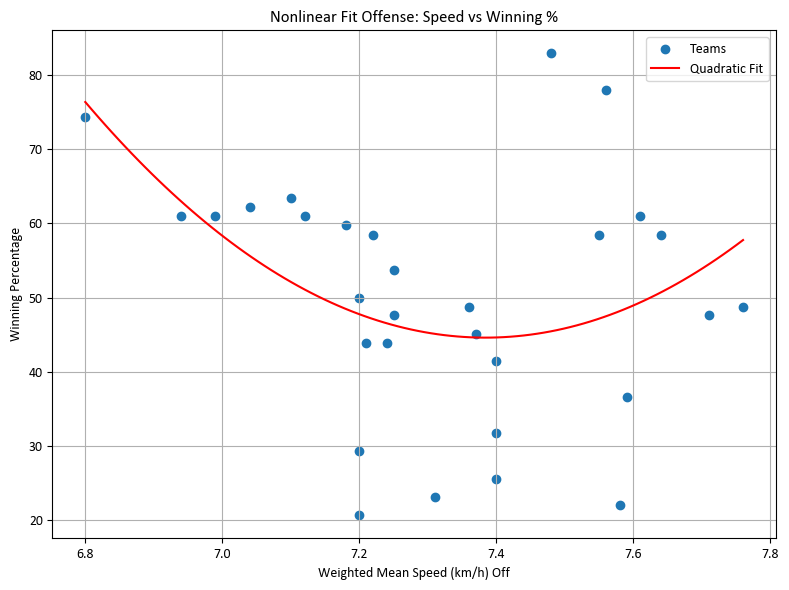

In [96]:
coeffs_kmh_off = np.polyfit(x, y, 2)
poly = np.poly1d(coeffs_kmh_off)

x_fit = np.linspace(x.min(), x.max(), 100)

plt.figure(figsize=(8,6))
plt.scatter(x, y, label='Teams')
plt.plot(x_fit, poly(x_fit), color='red', label='Quadratic Fit')
plt.xlabel('Weighted Mean Speed (km/h) Off')
plt.ylabel('Winning Percentage')
plt.title('Nonlinear Fit Offense: Speed vs Winning %')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [97]:
y_pred = poly(x)
r2 = r2_score(y, y_pred)
print(f"R²: {r2:.3f}")


R²: 0.175


In [98]:
optimal_speed_off = -coeffs_kmh_off[1] / (2 * coeffs_kmh_off[0])
print(f"Optimal speed (golden line): {optimal_speed_off:.3f} km/h")

Optimal speed (golden line): 7.384 km/h


In [99]:
# Create distance bands
team_summary_kmh_off['Distance Band'] = pd.cut(
    team_summary_kmh_off['Weighted Mean Speed (km/h) Off'],
    bins=[6.8, 7, 7.2, 7.4, 7.6, 7.8],
    include_lowest=True
)

# Compute average win % per band
band_win_pct_kmh_off = team_summary_kmh_off.groupby('Distance Band')['Win PCT'].mean().sort_index()

print(band_win_pct_kmh_off)



Distance Band
(6.7989999999999995, 7.0]    65.466667
(7.0, 7.2]                   49.485714
(7.2, 7.4]                   42.136364
(7.4, 7.6]                   55.600000
(7.6, 7.8]                   53.975000
Name: Win PCT, dtype: float64


C:\Users\modri\AppData\Local\Temp\ipykernel_9604\2843071463.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  band_win_pct_kmh_off = team_summary_kmh_off.groupby('Distance Band')['Win PCT'].mean().sort_index()


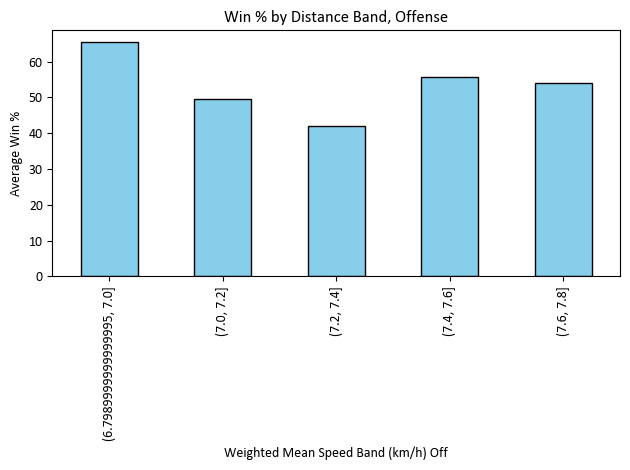

In [100]:
band_win_pct_kmh_off.plot(kind='bar', color='skyblue', edgecolor='black')
plt.ylabel('Average Win %')
plt.xlabel('Weighted Mean Speed Band (km/h) Off')
plt.title('Win % by Distance Band, Offense')
plt.tight_layout()
plt.show()

In [101]:
print(team_summary_kmh_off['Distance Band'].value_counts().sort_index())


Distance Band
(6.7989999999999995, 7.0]     3
(7.0, 7.2]                    7
(7.2, 7.4]                   11
(7.4, 7.6]                    5
(7.6, 7.8]                    4
Name: count, dtype: int64


In [102]:
# Prepare win % lists for each band
groups_kmh_off = [
    team_summary_kmh_off.loc[team_summary_kmh_off['Distance Band'] == band, 'Win PCT'].values
    for band in band_win_pct_kmh_off.index
]

# Run ANOVA
f_stat, p_value = f_oneway(*groups_kmh_off)
print(f"ANOVA F-statistic: {f_stat:.3f}, p-value: {p_value:.3f}")


ANOVA F-statistic: 1.669, p-value: 0.189


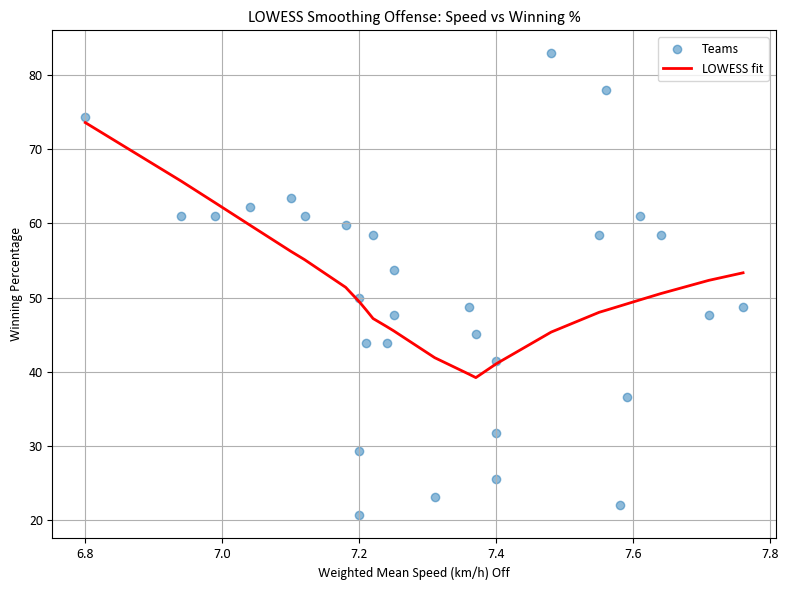

In [103]:
# Apply LOWESS
smoothed = lowess(y, x, frac=0.6)  

# Plot
plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.5, label='Teams')
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', linewidth=2, label='LOWESS fit')
plt.xlabel("Weighted Mean Speed (km/h) Off")
plt.ylabel("Winning Percentage")
plt.title("LOWESS Smoothing Offense: Speed vs Winning %")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Average Apeed km/h Def

In [104]:
team_mean_avg_kmh_def = nba_df.groupby('TEAM')['Avg Speed (km/h) Def'].mean().round(2)
team_mean_avg_kmh_def.sort_values(ascending=False, inplace=True)
team_mean_avg_kmh_def

TEAM
IND    6.76
MEM    6.67
TOR    6.66
BKN    6.63
GSW    6.62
POR    6.62
MIN    6.62
UTA    6.60
ORL    6.57
NOP    6.56
CHA    6.52
LAL    6.52
MIA    6.51
CLE    6.50
OKC    6.49
DAL    6.49
NYK    6.48
WAS    6.47
DET    6.47
SAS    6.47
ATL    6.46
PHX    6.44
MIL    6.43
HOU    6.42
CHI    6.38
LAC    6.38
BOS    6.35
SAC    6.31
PHI    6.31
DEN    6.24
Name: Avg Speed (km/h) Def, dtype: float64

In [105]:
# Calculate the weighted speed sum and the total minutes per team
weighted_avg_kmh_def = nba_df.groupby('TEAM').apply(
    lambda x: (x['Avg Speed (km/h) Def'] * x['MIN']).sum() / x['MIN'].sum()
).round(2)


weighted_avg_kmh_def = weighted_avg_kmh_def.rename('Weighted Mean Speed (km/h) Def')
weighted_avg_kmh_def = weighted_avg_kmh_def.sort_values(ascending=False)
weighted_avg_kmh_def

C:\Users\modri\AppData\Local\Temp\ipykernel_9604\4165398856.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_avg_kmh_def = nba_df.groupby('TEAM').apply(


TEAM
IND    6.66
MEM    6.64
TOR    6.64
BKN    6.61
UTA    6.56
POR    6.54
NOP    6.53
GSW    6.50
MIA    6.48
CHA    6.48
ORL    6.44
WAS    6.43
MIN    6.41
ATL    6.40
DET    6.40
OKC    6.40
SAC    6.39
NYK    6.39
CLE    6.39
SAS    6.37
HOU    6.37
PHX    6.37
CHI    6.36
DAL    6.35
MIL    6.35
LAL    6.34
PHI    6.29
BOS    6.27
LAC    6.25
DEN    6.14
Name: Weighted Mean Speed (km/h) Def, dtype: float64

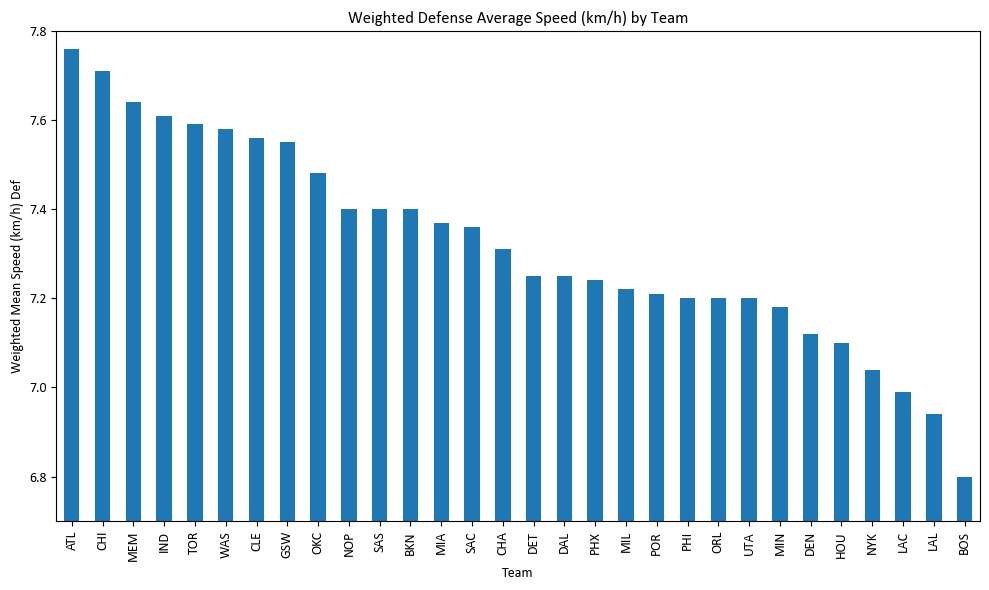

In [106]:
plt.figure(figsize=(10,6))
weighted_avg_kmh_off.plot(kind='bar')

plt.xlabel('Team')
plt.ylabel('Weighted Mean Speed (km/h) Def')
plt.title('Weighted Defense Average Speed (km/h) by Team')
plt.ylim(6.7, 7.8)  
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [107]:
# Convert  Series to DataFrame with 'TEAM' as a column
weighted_avg_kmh_df_def = weighted_avg_kmh_def.reset_index().rename(columns={'index': 'TEAM', 0: 'Weighted Mean Speed (km/h) Def'})

# Merge with nba_standings on 'TEAM'
team_summary_kmh_def = pd.merge(weighted_avg_kmh_df_def, nba_standings[['TEAM', 'PCT']], on='TEAM', how='inner')

# Convert 'PCT' to percentage format
team_summary_kmh_def['PCT'] = (team_summary_kmh_def['PCT'] * 100).round(2)

# Rename columns for clarity
team_summary_kmh_def = team_summary_kmh_def.rename(columns={'PCT': 'Win PCT'})

print(team_summary_kmh_def.head())


  TEAM  Weighted Mean Speed (km/h) Def  Win PCT
0  IND                            6.66     61.0
1  MEM                            6.64     58.5
2  TOR                            6.64     36.6
3  BKN                            6.61     31.7
4  UTA                            6.56     20.7


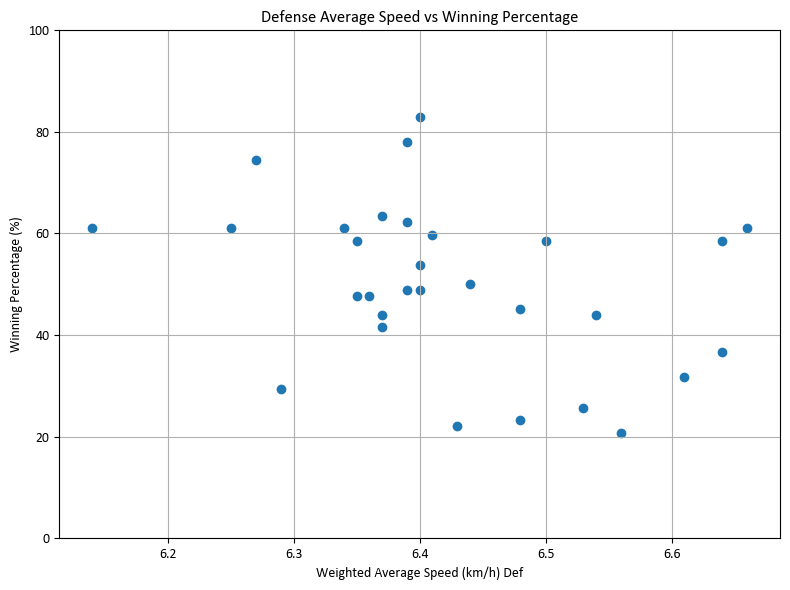

In [108]:
x = team_summary_kmh_def['Weighted Mean Speed (km/h) Def']
y = team_summary_kmh_def['Win PCT']

plt.figure(figsize=(8,6))
plt.scatter(x, y)
plt.xlabel('Weighted Average Speed (km/h) Def')
plt.ylabel('Winning Percentage (%)')
plt.title('Defense Average Speed vs Winning Percentage')

# Set axis limits
plt.xlim(None, None)
plt.ylim(0, 100)

plt.grid(True)
plt.tight_layout()
plt.show()


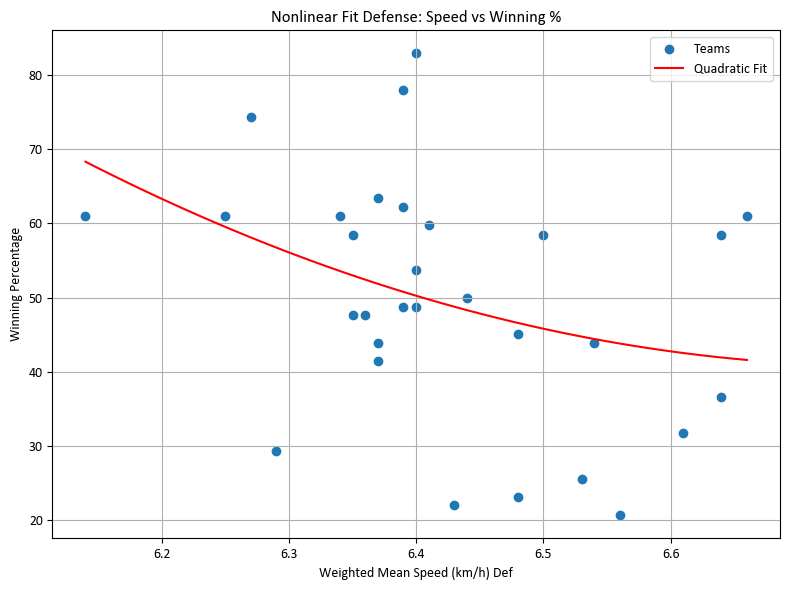

In [109]:
coeffs_kmh_def = np.polyfit(x, y, 2)
poly = np.poly1d(coeffs_kmh_def)

x_fit = np.linspace(x.min(), x.max(), 100)

plt.figure(figsize=(8,6))
plt.scatter(x, y, label='Teams')
plt.plot(x_fit, poly(x_fit), color='red', label='Quadratic Fit')
plt.xlabel('Weighted Mean Speed (km/h) Def')
plt.ylabel('Winning Percentage')
plt.title('Nonlinear Fit Defense: Speed vs Winning %')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [110]:
y_pred = poly(x)
r2 = r2_score(y, y_pred)
print(f"R²: {r2:.3f}")


R²: 0.128


In [111]:
optimal_speed_def = -coeffs_kmh_def[1] / (2 * coeffs_kmh_def[0])
print(f"Optimal speed (golden line): {optimal_speed_def:.3f} km/h")

Optimal speed (golden line): 6.769 km/h


In [112]:
# Create speed bands
team_summary_kmh_def['Speed Band'] = pd.cut(
    team_summary_kmh_def['Weighted Mean Speed (km/h) Def'],
    bins=[6.1, 6.3, 6.5, 6.7],
    include_lowest=True
)

# Compute average win % per band
band_win_pct_kmh_def = team_summary_kmh_def.groupby('Speed Band')['Win PCT'].mean().sort_index()

print(band_win_pct_kmh_def)

Speed Band
(6.098999999999999, 6.3]    56.425000
(6.3, 6.5]                  52.447368
(6.5, 6.7]                  39.714286
Name: Win PCT, dtype: float64


C:\Users\modri\AppData\Local\Temp\ipykernel_9604\828204319.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  band_win_pct_kmh_def = team_summary_kmh_def.groupby('Speed Band')['Win PCT'].mean().sort_index()


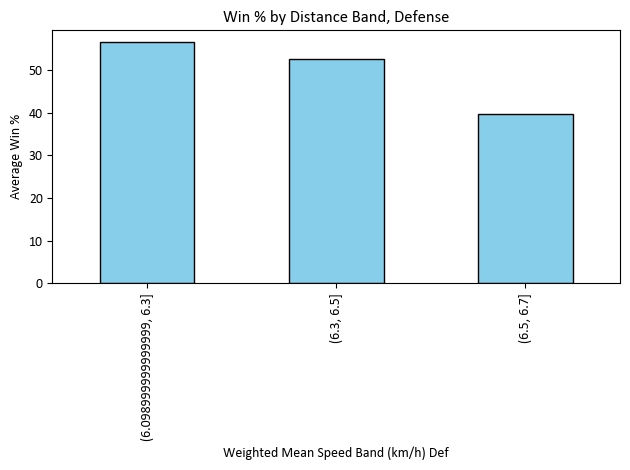

In [113]:
band_win_pct_kmh_def.plot(kind='bar', color='skyblue', edgecolor='black')
plt.ylabel('Average Win %')
plt.xlabel('Weighted Mean Speed Band (km/h) Def')
plt.title('Win % by Distance Band, Defense')
plt.tight_layout()
plt.show()

In [114]:
print(team_summary_kmh_def['Speed Band'].value_counts().sort_index())


Speed Band
(6.098999999999999, 6.3]     4
(6.3, 6.5]                  19
(6.5, 6.7]                   7
Name: count, dtype: int64


In [115]:
# Prepare win % lists for each band
groups_kmh_def = [
    team_summary_kmh_def.loc[team_summary_kmh_def['Speed Band'] == band, 'Win PCT'].values
    for band in band_win_pct_kmh_def.index
]

# Run ANOVA
f_stat, p_value = f_oneway(*groups_kmh_def)
print(f"ANOVA F-statistic: {f_stat:.3f}, p-value: {p_value:.3f}")

ANOVA F-statistic: 2.065, p-value: 0.146


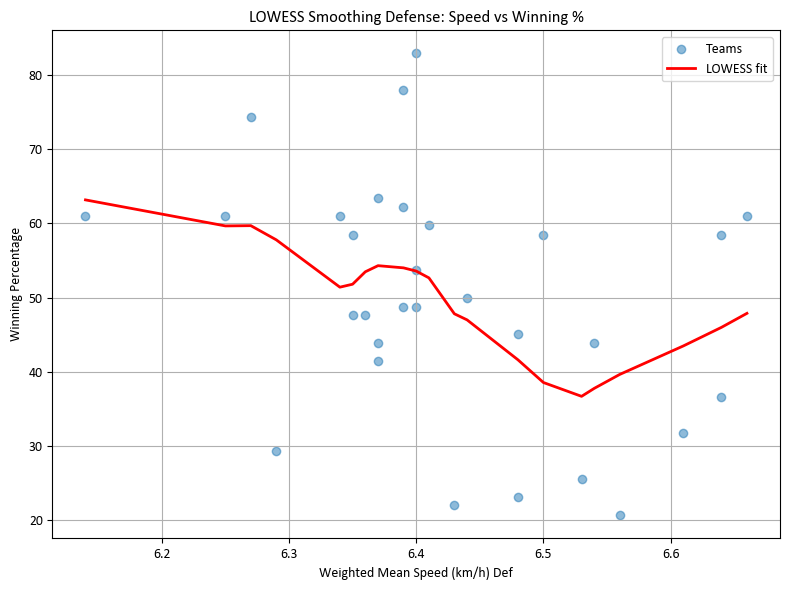

In [116]:
# Apply LOWESS
smoothed = lowess(y, x, frac=0.6)  

# Plot
plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.5, label='Teams')
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', linewidth=2, label='LOWESS fit')
plt.xlabel("Weighted Mean Speed (km/h) Def")
plt.ylabel("Winning Percentage")
plt.title("LOWESS Smoothing Defense: Speed vs Winning %")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Combining Speed and Distance

In [117]:
team_summary_df = [
    "team_summary",
    "team_summary_def",
    "team_summary_kmh",
    "team_summary_kmh_def",
    "team_summary_kmh_off",
    "team_summary_off"
]
print(team_summary_df)

['team_summary', 'team_summary_def', 'team_summary_kmh', 'team_summary_kmh_def', 'team_summary_kmh_off', 'team_summary_off']


In [118]:
dfs_columns = [team_summary, team_summary_def, team_summary_kmh, team_summary_kmh_def, team_summary_kmh_off, team_summary_off]
all_columns = set()
for df in dfs_columns:
    all_columns.update(df.columns)
print(sorted(all_columns))

['Distance Band', 'Speed Band', 'TEAM', 'Weighted Mean Dist (KM)', 'Weighted Mean Dist (KM) Def', 'Weighted Mean Dist (KM) Off', 'Weighted Mean Speed (km/h)', 'Weighted Mean Speed (km/h) Def', 'Weighted Mean Speed (km/h) Off', 'Win PCT']


In [119]:
# Example: select only TEAM + relevant columns
team_summary = team_summary[['TEAM', 'Win PCT']]  # only one 'Win PCT'
team_summary_def = team_summary_def[['TEAM', 'Weighted Mean Dist (KM) Def']]
team_summary_off = team_summary_off[['TEAM', 'Weighted Mean Dist (KM) Off']]
team_summary_kmh = team_summary_kmh[['TEAM', 'Weighted Mean Speed (km/h)']]
team_summary_kmh_def = team_summary_kmh_def[['TEAM', 'Weighted Mean Speed (km/h) Def']]
team_summary_kmh_off = team_summary_kmh_off[['TEAM', 'Weighted Mean Speed (km/h) Off']]


In [120]:
dfs = [team_summary, team_summary_def, team_summary_off,
       team_summary_kmh, team_summary_kmh_def, team_summary_kmh_off]

combined_df = reduce(lambda left, right: pd.merge(left, right, on='TEAM'), dfs)
print (combined_df.head())

  TEAM  Win PCT  Weighted Mean Dist (KM) Def  Weighted Mean Dist (KM) Off  \
0  NYK     62.2                         1.43                         1.69   
1  SAC     48.8                         1.46                         1.66   
2  ATL     48.8                         1.43                         1.61   
3  NOP     25.6                         1.41                         1.61   
4  DEN     61.0                         1.42                         1.59   

   Weighted Mean Speed (km/h)  Weighted Mean Speed (km/h) Def  \
0                        6.72                            6.39   
1                        6.89                            6.39   
2                        7.06                            6.40   
3                        6.97                            6.53   
4                        6.62                            6.14   

   Weighted Mean Speed (km/h) Off  
0                            7.04  
1                            7.36  
2                            7.76  
3 

In [121]:
print(combined_df.columns.tolist())


['TEAM', 'Win PCT', 'Weighted Mean Dist (KM) Def', 'Weighted Mean Dist (KM) Off', 'Weighted Mean Speed (km/h)', 'Weighted Mean Speed (km/h) Def', 'Weighted Mean Speed (km/h) Off']


Win PCT                           1.000000
Weighted Mean Dist (KM) Def      -0.178753
Weighted Mean Dist (KM) Off      -0.394964
Weighted Mean Speed (km/h)       -0.298972
Weighted Mean Speed (km/h) Def   -0.347602
Weighted Mean Speed (km/h) Off   -0.186659
Name: Win PCT, dtype: float64


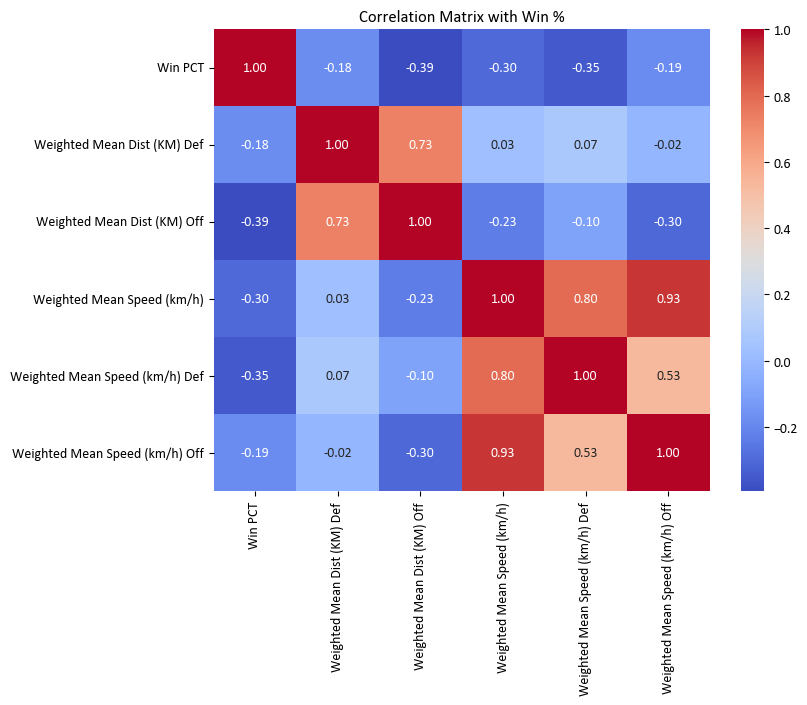

In [122]:
correlation_df = combined_df[
    ['Win PCT',
     'Weighted Mean Dist (KM) Def',
     'Weighted Mean Dist (KM) Off',
     'Weighted Mean Speed (km/h)',
     'Weighted Mean Speed (km/h) Def',
     'Weighted Mean Speed (km/h) Off']
]
corr_matrix = correlation_df.corr()

# Print correlation with Win PCT
print(corr_matrix['Win PCT'])

# heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix with Win %")
plt.show()


#### Regression

In [123]:
features = [
    'Weighted Mean Dist (KM) Def',
    'Weighted Mean Dist (KM) Off',
    'Weighted Mean Speed (km/h) Def',
    'Weighted Mean Speed (km/h) Off'
]
target = 'Win PCT'

X = combined_df[features]
y = combined_df[target]
print(X.isnull().sum())
print(y.isnull().sum())


Weighted Mean Dist (KM) Def       0
Weighted Mean Dist (KM) Off       0
Weighted Mean Speed (km/h) Def    0
Weighted Mean Speed (km/h) Off    0
dtype: int64
0


In [124]:
# Add intercept
X_const = sm.add_constant(X)

model = sm.OLS(y, X_const).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                Win PCT   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     4.373
Date:                Sun, 13 Jul 2025   Prob (F-statistic):            0.00811
Time:                        15:06:30   Log-Likelihood:                -117.80
No. Observations:                  30   AIC:                             245.6
Df Residuals:                      25   BIC:                             252.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [125]:


# Assuming X is your feature dataframe
# If there are any missing values, you may want to drop or fill them first:
X = X.dropna()

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                          feature          VIF
0     Weighted Mean Dist (KM) Def  1992.038134
1     Weighted Mean Dist (KM) Off  1707.030894
2  Weighted Mean Speed (km/h) Def  2440.889132
3  Weighted Mean Speed (km/h) Off  1528.639927


# Player Analysis

## Defense

In [126]:
dws_filter = dws[(dws['MIN'] >= 13) & (dws['GP'] >= 41)].copy()
print(dws_filter.shape)
dws_filter.head()

(304, 20)


,Player,TEAM,AGE,GP,W,L,MIN,DEF RTG,DREB,DREB%,%DREB,STL,STL%,BLK,%BLK,OPP PTS OFF TOV,OPP PTS 2ND CHANCE,OPP PTS FB,"OPP PTS, PAINT",DEF WS
0,Shai Gilgeous-Alexander,OKC,26,76,63,13,34.2,105.7,4.1,11.2,16.9,1.7,23.0,1.0,23.1,8.6,10.9,8.6,30.2,0.168
1,Franz Wagner,ORL,23,60,33,27,33.7,105.8,4.8,14.6,21.4,1.3,19.4,0.4,8.5,10.6,8.3,9.5,30.8,0.166
3,Jalen Williams,OKC,24,69,55,14,32.4,106.5,4.5,13.1,20.1,1.6,21.0,0.7,16.8,8.8,10.2,8.6,29.5,0.154
5,Ivica Zubac,LAC,28,80,50,30,32.8,107.1,8.9,27.1,38.3,0.7,10.4,1.1,40.4,12.1,8.0,10.2,30.9,0.147
6,Norman Powell,LAC,32,60,39,21,32.6,107.4,2.8,8.5,12.2,1.2,18.8,0.2,5.1,11.7,7.9,10.1,31.0,0.146


In [127]:
dws_filter_sorted = dws_filter.sort_values(by='DEF WS', ascending=False)
dws_filter_sorted.head()

,Player,TEAM,AGE,GP,W,L,MIN,DEF RTG,DREB,DREB%,%DREB,STL,STL%,BLK,%BLK,OPP PTS OFF TOV,OPP PTS 2ND CHANCE,OPP PTS FB,"OPP PTS, PAINT",DEF WS
0,Shai Gilgeous-Alexander,OKC,26,76,63,13,34.2,105.7,4.1,11.2,16.9,1.7,23.0,1.0,23.1,8.6,10.9,8.6,30.2,0.168
1,Franz Wagner,ORL,23,60,33,27,33.7,105.8,4.8,14.6,21.4,1.3,19.4,0.4,8.5,10.6,8.3,9.5,30.8,0.166
3,Jalen Williams,OKC,24,69,55,14,32.4,106.5,4.5,13.1,20.1,1.6,21.0,0.7,16.8,8.8,10.2,8.6,29.5,0.154
5,Ivica Zubac,LAC,28,80,50,30,32.8,107.1,8.9,27.1,38.3,0.7,10.4,1.1,40.4,12.1,8.0,10.2,30.9,0.147
6,Norman Powell,LAC,32,60,39,21,32.6,107.4,2.8,8.5,12.2,1.2,18.8,0.2,5.1,11.7,7.9,10.1,31.0,0.146


In [128]:
dist_filtered = nba_df[(nba_df['MIN'] >= 13) & (nba_df['GP'] >= 41)].copy()


In [129]:
dist_filtered_sorted = dist_filtered.sort_values(by='Dist. KM Def', ascending=False)
dist_filtered_sorted

,PLAYER,TEAM,GP,W,L,MIN,Dist. Feet,Dist. Miles,Dist. Miles Off,Dist. Miles Def,Avg Speed (mph),Avg Speed Off,Avg Speed Def,Dist. KM,Dist. KM Off,Dist. KM Def,Avg Speed (km/h),Avg Speed (km/h) Off,Avg Speed (km/h) Def
25,Toumani Camara,POR,78,33,45,32.7,14039.4,2.66,1.34,1.32,4.57,4.66,4.49,4.28,2.16,2.12,7.35,7.50,7.23
153,Keegan Murray,SAC,76,36,40,34.3,14253.1,2.70,1.40,1.30,4.41,4.67,4.17,4.35,2.25,2.09,7.10,7.52,6.71
249,Dyson Daniels,ATL,76,37,39,33.8,14263.0,2.70,1.42,1.29,4.49,4.95,4.07,4.35,2.29,2.08,7.23,7.97,6.55
245,Mikal Bridges,NYK,82,51,31,37.0,14878.1,2.82,1.54,1.28,4.30,4.51,4.08,4.54,2.48,2.06,6.92,7.26,6.57
495,De'Aaron Fox,SAS,62,27,35,36.1,14513.2,2.75,1.48,1.27,4.25,4.75,3.78,4.43,2.38,2.04,6.84,7.64,6.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,Pat Connaughton,MIL,41,19,22,14.7,6072.6,1.15,0.65,0.50,4.39,4.84,3.90,1.85,1.05,0.80,7.07,7.79,6.28
214,Caleb Houstan,ORL,58,29,29,13.6,5826.2,1.10,0.61,0.49,4.49,4.86,4.10,1.77,0.98,0.79,7.23,7.82,6.60
259,Neemias Queta,BOS,62,46,16,13.9,5329.6,1.01,0.52,0.49,4.08,4.10,4.06,1.63,0.84,0.79,6.57,6.60,6.53
458,Jalen Pickett,DEN,49,31,18,13.6,5482.7,1.04,0.57,0.47,4.25,4.66,3.84,1.67,0.92,0.76,6.84,7.50,6.18


In [130]:
# change column name for consistency
dist_filtered_sorted = dist_filtered_sorted.rename(columns={'PLAYER': 'Player'})

In [131]:
# Merge dist_filtered_sorted and dws_filter_sorted on 'Player'
combined_player_filtered = pd.merge(dist_filtered_sorted, dws_filter_sorted, on='Player')
print (combined_player_filtered.shape)
combined_player_filtered.head()

(304, 38)


,Player,TEAM_x,GP_x,W_x,L_x,MIN_x,Dist. Feet,Dist. Miles,Dist. Miles Off,Dist. Miles Def,...,%DREB,STL,STL%,BLK,%BLK,OPP PTS OFF TOV,OPP PTS 2ND CHANCE,OPP PTS FB,"OPP PTS, PAINT",DEF WS
0,Toumani Camara,POR,78,33,45,32.7,14039.4,2.66,1.34,1.32,...,16.9,1.5,26.5,0.6,18.7,13.6,10.0,12.2,32.4,0.088
1,Keegan Murray,SAC,76,36,40,34.3,14253.1,2.70,1.40,1.30,...,19.4,0.8,15.8,0.9,29.5,11.5,9.6,8.9,33.2,0.094
2,Dyson Daniels,ATL,76,37,39,33.8,14263.0,2.70,1.42,1.29,...,18.9,3.0,41.0,0.7,20.1,14.1,9.2,11.8,36.4,0.083
3,Mikal Bridges,NYK,82,51,31,37.0,14878.1,2.82,1.54,1.28,...,9.5,0.9,14.7,0.5,17.6,11.9,9.8,11.4,38.7,0.106
4,De'Aaron Fox,SAS,62,27,35,36.1,14513.2,2.75,1.48,1.27,...,16.1,1.5,25.1,0.4,12.4,11.7,11.0,9.3,35.9,0.083


In [132]:
# Remove '_x' or '_y' suffixes from column names in combined_player_filtered
combined_player_filtered.columns = combined_player_filtered.columns.str.replace(r'(_x|_y)$', '', regex=True)
print(combined_player_filtered.columns)

Index(['Player', 'TEAM', 'GP', 'W', 'L', 'MIN', 'Dist. Feet', 'Dist. Miles',
       'Dist. Miles Off', 'Dist. Miles Def', 'Avg Speed (mph)',
       'Avg Speed Off', 'Avg Speed Def', 'Dist. KM', 'Dist. KM Off',
       'Dist. KM Def', 'Avg Speed (km/h)', 'Avg Speed (km/h) Off',
       'Avg Speed (km/h) Def', 'TEAM', 'AGE', 'GP', 'W', 'L', 'MIN', 'DEF RTG',
       'DREB', 'DREB%', '%DREB', 'STL', 'STL%', 'BLK', '%BLK',
       'OPP PTS OFF TOV', 'OPP PTS 2ND CHANCE', 'OPP PTS FB', 'OPP PTS, PAINT',
       'DEF WS'],
      dtype='object')


In [133]:
# Calculate correlation between 'Avg Speed (km/h) Def' and 'DEF WS'
correlation_1 = combined_player_filtered['Avg Speed (km/h) Def'].corr(combined_player_filtered['DEF WS'])
print(f"Correlation between Avg Speed (km/h) Def and DEF WS: {correlation_1:.3f}")

Correlation between Avg Speed (km/h) Def and DEF WS: -0.290


In [134]:
correlation_2 = combined_player_filtered['Dist. KM Def'].corr(combined_player_filtered['DEF WS'])
print(f"Correlation between Dist. KM Def and DEF WS: {correlation_2:.3f}")

Correlation between Dist. KM Def and DEF WS: 0.461


In [135]:
# Calculate the combined correlation (multiple correlation coefficient, R) between 'Dist. KM Def' and 'Avg Speed (km/h) Def' with 'DEF WS'

# Select relevant columns and drop NA if any
cols = ['Dist. KM Def', 'Avg Speed (km/h) Def', 'DEF WS']
df_corr = combined_player_filtered[cols].dropna()

# Calculate the multiple correlation coefficient (R)
corr_matrix = df_corr.corr()
r_yx1 = corr_matrix.loc['DEF WS', 'Dist. KM Def']
r_yx2 = corr_matrix.loc['DEF WS', 'Avg Speed (km/h) Def']
r_x1x2 = corr_matrix.loc['Dist. KM Def', 'Avg Speed (km/h) Def']

# Formula for multiple correlation coefficient R_y.x1x2
numerator = r_yx1**2 + r_yx2**2 - 2*r_yx1*r_yx2*r_x1x2
denominator = 1 - r_x1x2**2
R = sqrt(numerator / denominator)

print(f"Combined multiple correlation (R) between Dist. KM Def, Avg Speed (km/h) Def and DEF WS: {R:.3f}")

Combined multiple correlation (R) between Dist. KM Def, Avg Speed (km/h) Def and DEF WS: 0.489


## Offense

In [136]:
# Select only the relevant columns from ows_split: 'Player', 'WS', 'OWS', 'DWS'
ows_cols = ['Player', 'WS', 'OWS', 'DWS']
ows_selected = ows[ows_cols].copy()

In [137]:
# Merge with dws_filter_sorted on 'Player'
combined_ows_dws = pd.merge(combined_player_filtered, ows_selected, on='Player', how='left')
combined_ows_dws.head()

,Player,TEAM,GP,W,L,MIN,Dist. Feet,Dist. Miles,Dist. Miles Off,Dist. Miles Def,...,BLK,%BLK,OPP PTS OFF TOV,OPP PTS 2ND CHANCE,OPP PTS FB,"OPP PTS, PAINT",DEF WS,WS,OWS,DWS
0,Toumani Camara,POR,78,33,45,32.7,14039.4,2.66,1.34,1.32,...,0.6,18.7,13.6,10.0,12.2,32.4,0.088,5.2,2.5,2.6
1,Keegan Murray,SAC,76,36,40,34.3,14253.1,2.70,1.40,1.30,...,0.9,29.5,11.5,9.6,8.9,33.2,0.094,4.4,2.4,2.1
2,Dyson Daniels,ATL,76,37,39,33.8,14263.0,2.70,1.42,1.29,...,0.7,20.1,14.1,9.2,11.8,36.4,0.083,5.0,1.3,3.7
3,Mikal Bridges,NYK,82,51,31,37.0,14878.1,2.82,1.54,1.28,...,0.5,17.6,11.9,9.8,11.4,38.7,0.106,5.7,3.7,2.0
4,De'Aaron Fox,SAS,62,27,35,36.1,14513.2,2.75,1.48,1.27,...,0.4,12.4,11.7,11.0,9.3,35.9,0.083,4.3,2.6,1.7


In [138]:
# Calculate correlation between 'Avg Speed (km/h) Off' and 'OWS'
correlation_3 = combined_ows_dws['Avg Speed (km/h) Off'].corr(combined_ows_dws['OWS'])
print(f"Correlation between Avg Speed (km/h) ofense and offense WS: {correlation_3:.3f}")

Correlation between Avg Speed (km/h) ofense and offense WS: -0.266


In [139]:
correlation_4 = combined_ows_dws['Dist. KM Def'].corr(combined_ows_dws['OWS'])
print(f"Correlation between Dist. KM Def and offensive win shares: {correlation_4:.3f}")

Correlation between Dist. KM Def and offensive win shares: 0.444


In [140]:
# Calculate the combined correlation (multiple correlation coefficient, R) between 'Dist. KM Off' and 'Avg Speed (km/h) Off' with 'OWS'

# Select relevant columns and drop NA if any
cols_2 = ['Dist. KM Off', 'Avg Speed (km/h) Off', 'OWS']
df_corr_2 = combined_ows_dws[cols_2].dropna()

# Calculate the multiple correlation coefficient (R)
corr_matrix_2 = df_corr_2.corr()
r_yx1 = corr_matrix_2.loc['OWS', 'Dist. KM Off']
r_yx2 = corr_matrix_2.loc['OWS', 'Avg Speed (km/h) Off']
r_x1x2 = corr_matrix_2.loc['Dist. KM Off', 'Avg Speed (km/h) Off']

# Formula for multiple correlation coefficient R_y.x1x2
numerator = r_yx1**2 + r_yx2**2 - 2*r_yx1*r_yx2*r_x1x2
denominator = 1 - r_x1x2**2
R = sqrt(numerator / denominator)

print(f"Combined multiple correlation (R) between Dist. KM Off, Avg Speed (km/h) Off and OWS: {R:.3f}")

Combined multiple correlation (R) between Dist. KM Off, Avg Speed (km/h) Off and OWS: 0.517


In [141]:
# Calculate the correlation between Dist. KM Off, Dist. KM Def, Avg Speed (km/h) Def, Avg Speed (km/h) Off and WS

# Select relevant columns and drop NA if any
cols_ws = ['Dist. KM Off', 'Dist. KM Def', 'Avg Speed (km/h) Def', 'Avg Speed (km/h) Off', 'WS']
df_corr_ws = combined_ows_dws[cols_ws].dropna()

# Compute correlation matrix
corr_matrix_ws = df_corr_ws.corr()

# Print correlation of each variable with WS
print(corr_matrix_ws['WS'])

Dist. KM Off            0.493016
Dist. KM Def            0.500229
Avg Speed (km/h) Def   -0.443578
Avg Speed (km/h) Off   -0.311725
WS                      1.000000
Name: WS, dtype: float64


In [142]:
# Select relevant columns and drop NA if any
cols_ws = ['Dist. KM Off', 'Dist. KM Def', 'Avg Speed (km/h) Def', 'Avg Speed (km/h) Off', 'WS']
df_corr_ws = combined_ows_dws[cols_ws].dropna()

# Compute the correlation matrix
corr_matrix_ws = df_corr_ws.corr()

# Calculate the multiple correlation coefficient (R) for WS with the other variables

# Extract correlation submatrices
r_yx = corr_matrix_ws.loc['WS', df_corr_ws.columns.difference(['WS'])]
R_xx = corr_matrix_ws.loc[df_corr_ws.columns.difference(['WS']), df_corr_ws.columns.difference(['WS'])]

# Multiple correlation coefficient formula
R_squared = r_yx.values @ inv(R_xx.values) @ r_yx.values.T
R = np.sqrt(R_squared)

print(f"Multiple correlation coefficient (R) between predictors and WS: {R:.3f}")

Multiple correlation coefficient (R) between predictors and WS: 0.609


In [143]:
df_corr_ws['Dist. KM Off^2'] = df_corr_ws['Dist. KM Off'] ** 2
df_corr_ws['Avg Speed (km/h) Off^2'] = df_corr_ws['Avg Speed (km/h) Off'] ** 2

X = df_corr_ws[['Dist. KM Off', 'Avg Speed (km/h) Off',
                'Dist. KM Off^2', 'Avg Speed (km/h) Off^2']]
X = sm.add_constant(X)
y = df_corr_ws['WS']

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                     WS   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     39.64
Date:                Sun, 13 Jul 2025   Prob (F-statistic):           1.65e-26
Time:                        15:06:31   Log-Likelihood:                -646.05
No. Observations:                 297   AIC:                             1302.
Df Residuals:                     292   BIC:                             1321.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     86

### Plots

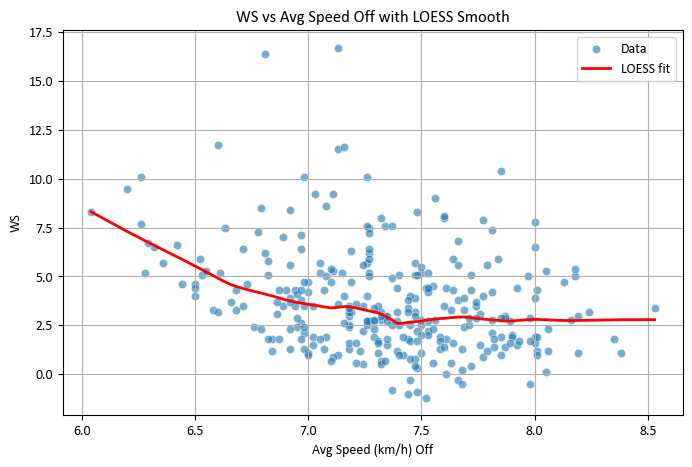

In [144]:
# Extract variables
x = df_corr_ws['Avg Speed (km/h) Off']
y = df_corr_ws['WS']

# Fit LOESS
lowess_fit = lowess(y, x, frac=0.3)

# Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=x, y=y, alpha=0.6, label='Data')
plt.plot(lowess_fit[:, 0], lowess_fit[:, 1], color='red', linewidth=2, label='LOESS fit')

plt.xlabel('Avg Speed (km/h) Off')
plt.ylabel('WS')
plt.title('WS vs Avg Speed Off with LOESS Smooth')
plt.legend()
plt.grid(True)
plt.show()


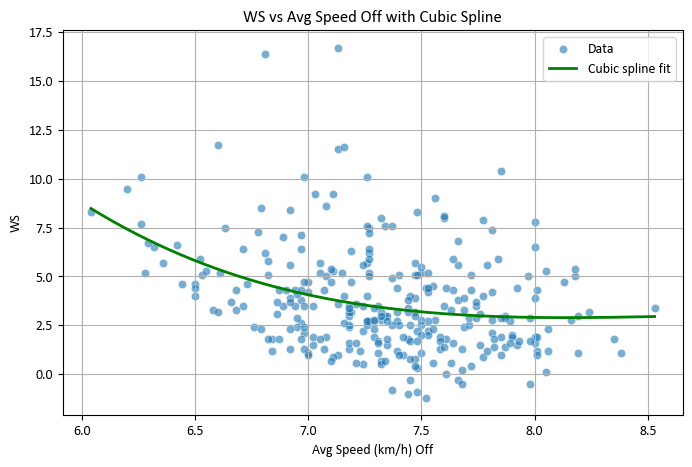

In [145]:


# Design matrix with cubic splines (df = degrees of freedom / flexibility)
x_spline = dmatrix("bs(x, df=4, degree=3, include_intercept=False)", {"x": x}, return_type='dataframe')

# Fit model
model = sm.OLS(y, x_spline).fit()

# Predict
x_seq = np.linspace(x.min(), x.max(), 300)
x_seq_spline = dmatrix("bs(x, df=4, degree=3, include_intercept=False)", {"x": x_seq}, return_type='dataframe')
y_pred = model.predict(x_seq_spline)

# Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=x, y=y, alpha=0.6, label='Data')
plt.plot(x_seq, y_pred, color='green', linewidth=2, label='Cubic spline fit')

plt.xlabel('Avg Speed (km/h) Off')
plt.ylabel('WS')
plt.title('WS vs Avg Speed Off with Cubic Spline')
plt.legend()
plt.grid(True)
plt.show()


## Player Top-20

In [146]:
combined_ows_dws

,Player,TEAM,GP,W,L,MIN,Dist. Feet,Dist. Miles,Dist. Miles Off,Dist. Miles Def,...,BLK,%BLK,OPP PTS OFF TOV,OPP PTS 2ND CHANCE,OPP PTS FB,"OPP PTS, PAINT",DEF WS,WS,OWS,DWS
0,Toumani Camara,POR,78,33,45,32.7,14039.4,2.66,1.34,1.32,...,0.6,18.7,13.6,10.0,12.2,32.4,0.088,5.2,2.5,2.6
1,Keegan Murray,SAC,76,36,40,34.3,14253.1,2.70,1.40,1.30,...,0.9,29.5,11.5,9.6,8.9,33.2,0.094,4.4,2.4,2.1
2,Dyson Daniels,ATL,76,37,39,33.8,14263.0,2.70,1.42,1.29,...,0.7,20.1,14.1,9.2,11.8,36.4,0.083,5.0,1.3,3.7
3,Mikal Bridges,NYK,82,51,31,37.0,14878.1,2.82,1.54,1.28,...,0.5,17.6,11.9,9.8,11.4,38.7,0.106,5.7,3.7,2.0
4,De'Aaron Fox,SAS,62,27,35,36.1,14513.2,2.75,1.48,1.27,...,0.4,12.4,11.7,11.0,9.3,35.9,0.083,4.3,2.6,1.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,Pat Connaughton,MIL,41,19,22,14.7,6072.6,1.15,0.65,0.50,...,0.3,15.3,5.5,4.4,3.7,14.0,0.034,1.2,0.6,0.6
300,Caleb Houstan,ORL,58,29,29,13.6,5826.2,1.10,0.61,0.49,...,0.1,6.5,5.1,3.8,3.8,13.5,0.057,1.8,0.9,0.9
301,Neemias Queta,BOS,62,46,16,13.9,5329.6,1.01,0.52,0.49,...,0.7,43.8,3.8,4.3,3.2,13.6,0.057,3.2,1.8,1.4
302,Jalen Pickett,DEN,49,31,18,13.6,5482.7,1.04,0.57,0.47,...,0.1,6.7,5.0,3.9,3.9,12.8,0.050,1.1,0.8,0.3


In [147]:
# Show top 20 players by 'Dist. KM' from combined_ows_dws
top20_dist_km = combined_ows_dws.nlargest(20, 'Dist. KM')
top20_dist_km[['Player', 'Dist. KM','WS']]

,Player,Dist. KM,WS
10,Tyrese Maxey,4.65,3.8
3,Mikal Bridges,4.54,5.7
5,Tyler Herro,4.47,7.4
4,De'Aaron Fox,4.43,4.3
9,Josh Hart,4.41,9.2
1,Keegan Murray,4.35,4.4
2,Dyson Daniels,4.35,5.0
21,Franz Wagner,4.30,5.6
24,Cade Cunningham,4.30,5.9
0,Toumani Camara,4.28,5.2


<Figure size 1200x600 with 0 Axes>

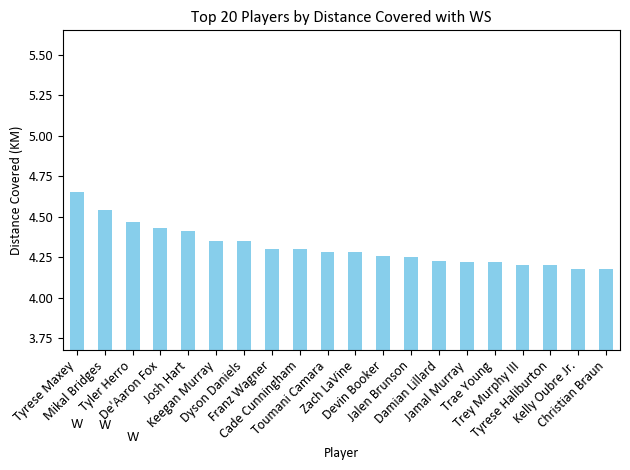

In [148]:
# Get top 20 players by distance
top20_dist_km = combined_ows_dws.nlargest(20, 'Dist. KM')

# Plotting
plt.figure(figsize=(12, 6))
ax = top20_dist_km.plot(
    kind='bar',
    x='Player',
    y='Dist. KM',
    legend=False,
    color='skyblue'
)

# Add 'W' labels manually – customize as needed
ax.text(0, sorted_dist.values[0] + 0.05, 'W', ha='center', va='bottom')   # 1st bar
ax.text(1, sorted_dist.values[1] + 0.05, 'W', ha='center', va='bottom')   # 2nd bar
ax.text(2, sorted_dist.values[2] + 0.05, 'W', ha='center', va='bottom')   # 3rd bar

# Axis labels and formatting
plt.xlabel('Player')
plt.ylabel('Distance Covered (KM)')
plt.title('Top 20 Players by Distance Covered with WS')
plt.xticks(rotation=45, ha='right')
plt.ylim(top20_dist_km['Dist. KM'].min() - 0.5, top20_dist_km['Dist. KM'].max() + 1)
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

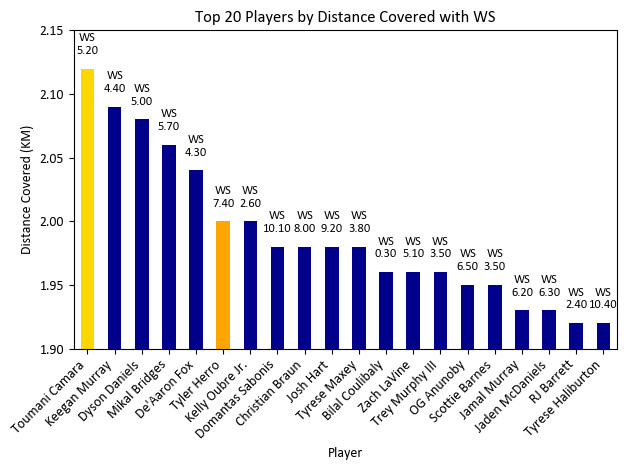

In [149]:
# Get top 20 players by distance
top20_dist_km = combined_ows_dws.nlargest(20, 'Dist. KM Def').copy()
top20_dist_km.rename(columns={'Dist. KM Def': 'Dist_KM'}, inplace=True)

# Define fresh color list
colors = ['darkblue'] * len(top20_dist_km)  # Always recreate this
colors[0] = 'gold'      # 1st player
colors[5] = 'orange'    # 6th player only

# Plotting
plt.figure(figsize=(12, 6))
ax = top20_dist_km.plot(
    kind='bar',
    x='Player',
    y='Dist_KM',
    legend=False,
    color=colors
)

# Add stacked text above each bar
for i, row in enumerate(top20_dist_km.itertuples()):
    ax.text(
        i, row.Dist_KM + 0.01, f"WS\n{row.WS:.2f}",
        ha='center', va='bottom',
        fontsize=9, fontname='Calibri'
    )

# Formatting
plt.xlabel('Player')
plt.ylabel('Distance Covered (KM)')
plt.title('Top 20 Players by Distance Covered with WS')
plt.xticks(rotation=45, ha='right')
plt.ylim(1.9, 2.15)
plt.tight_layout()
plt.show()


<Figure size 1400x600 with 0 Axes>

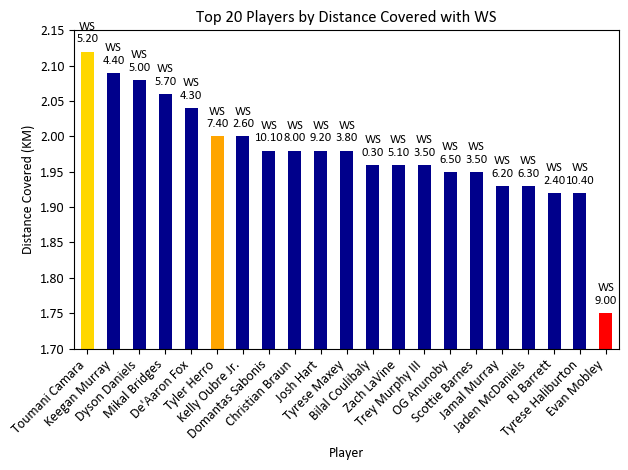

In [150]:
# Get top 20 players
top20_dist_km = combined_ows_dws.nlargest(20, 'Dist. KM Def').copy()
top20_dist_km.rename(columns={'Dist. KM Def': 'Dist_KM'}, inplace=True)

# Get the player at index 70
player_70 = combined_ows_dws.loc[70].copy()
player_70.rename({'Dist. KM Def': 'Dist_KM'}, inplace=True)

# Append player 70 if not already in top20
if player_70['Player'] not in top20_dist_km['Player'].values:
    top20_dist_km = pd.concat([top20_dist_km, player_70.to_frame().T], ignore_index=True)


# Create colors
colors = ['darkblue'] * len(top20_dist_km)
colors[0] = 'gold'       # top player
colors[5] = 'orange'     # 6th player

# Highlight player 70 in red (last bar)
idx_70 = top20_dist_km.index[top20_dist_km['Player'] == player_70['Player']][0]
colors[idx_70] = 'red'

# Plotting
plt.figure(figsize=(14, 6))
ax = top20_dist_km.plot(
    kind='bar',
    x='Player',
    y='Dist_KM',
    legend=False,
    color=colors
)

# Add text above bars
for i, row in enumerate(top20_dist_km.itertuples()):
    ax.text(
        i, row.Dist_KM + 0.01, f"WS\n{row.WS:.2f}",
        ha='center', va='bottom',
        fontsize=9, fontname='Calibri'
    )

plt.xlabel('Player')
plt.ylabel('Distance Covered (KM)')
plt.title('Top 20 Players by Distance Covered with WS')
plt.xticks(rotation=45, ha='right')
plt.ylim(top20_dist_km['Dist_KM'].min() - 0.5, top20_dist_km['Dist_KM'].max() + 1)
plt.tight_layout()
plt.ylim(1.7, 2.15)
plt.show()


In [151]:
top20_dist_km_off = combined_ows_dws.nlargest(20, 'Dist. KM Off')
top20_dist_km_off[['Player', 'Dist. KM Off', 'OWS']]

,Player,Dist. KM Off,OWS
10,Tyrese Maxey,2.67,2.9
3,Mikal Bridges,2.48,3.7
5,Tyler Herro,2.48,4.7
51,Jalen Brunson,2.45,6.8
9,Josh Hart,2.43,5.4
21,Franz Wagner,2.41,2.6
24,Cade Cunningham,2.41,3.0
30,Devin Booker,2.40,6.1
4,De'Aaron Fox,2.38,2.6
29,Damian Lillard,2.35,5.6


In [152]:
top20_dist_km_def = combined_ows_dws.nlargest(20, 'Dist. KM Def')
top20_dist_km_def[['Player', 'Dist. KM Def', 'DWS']]

,Player,Dist. KM Def,DWS
0,Toumani Camara,2.12,2.6
1,Keegan Murray,2.09,2.1
2,Dyson Daniels,2.08,3.7
3,Mikal Bridges,2.06,2.0
4,De'Aaron Fox,2.04,1.7
5,Tyler Herro,2.00,2.7
6,Kelly Oubre Jr.,2.00,1.4
7,Domantas Sabonis,1.98,2.7
8,Christian Braun,1.98,1.9
9,Josh Hart,1.98,3.8


In [153]:
top20_speed = combined_ows_dws.nlargest(20, 'Avg Speed (km/h)')
top20_speed[['Player', 'Avg Speed (km/h)', 'WS']]

,Player,Avg Speed (km/h),WS
272,Andre Jackson Jr.,7.77,1.2
259,Gary Payton II,7.72,3.0
110,Zaccharie Risacher,7.71,1.8
232,T.J. McConnell,7.69,3.2
215,Johnny Juzang,7.66,1.6
286,Dalen Terry,7.63,1.1
198,Ben Sheppard,7.60,2.1
189,Jake LaRavia,7.58,2.9
182,Scotty Pippen Jr.,7.56,4.7
115,Max Strus,7.55,3.4


In [154]:
top20_speed_off = combined_ows_dws.nlargest(20, 'Avg Speed (km/h) Off')
top20_speed[['Player', 'Avg Speed (km/h) Off', 'OWS']]

,Player,Avg Speed (km/h) Off,OWS
272,Andre Jackson Jr.,8.06,0.1
259,Gary Payton II,8.19,1.5
110,Zaccharie Risacher,8.35,0.6
232,T.J. McConnell,8.24,1.5
215,Johnny Juzang,8.00,1.3
286,Dalen Terry,8.38,0.2
198,Ben Sheppard,7.81,1.0
189,Jake LaRavia,7.98,1.4
182,Scotty Pippen Jr.,8.13,2.4
115,Max Strus,8.53,2.2


In [155]:
top20_speed_def = combined_ows_dws.nlargest(20, 'Avg Speed (km/h) Def')
top20_speed[['Player', 'Avg Speed (km/h) Def', 'DWS']]

,Player,Avg Speed (km/h) Def,DWS
272,Andre Jackson Jr.,7.48,1.0
259,Gary Payton II,7.31,1.5
110,Zaccharie Risacher,7.13,1.1
232,T.J. McConnell,7.18,1.7
215,Johnny Juzang,7.26,0.3
286,Dalen Terry,6.95,0.8
198,Ben Sheppard,7.40,1.0
189,Jake LaRavia,7.18,1.5
182,Scotty Pippen Jr.,7.02,2.3
115,Max Strus,6.66,1.3


<Figure size 1400x600 with 0 Axes>

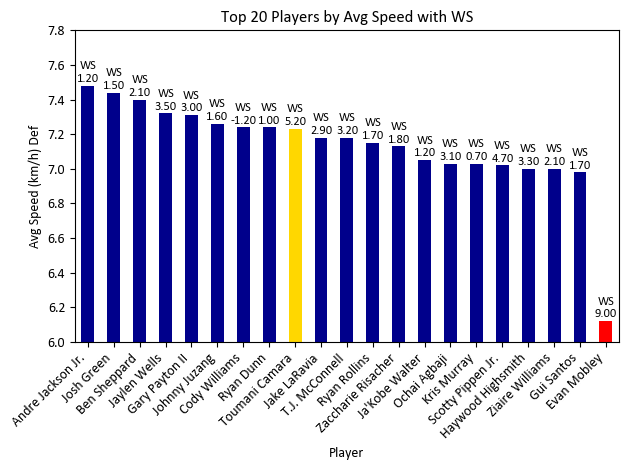

In [156]:
# Get top 20 players by Avg Speed Def
top20_speed_def = combined_ows_dws.nlargest(20, 'Avg Speed (km/h) Def').copy()

# Rename the column to a simpler name without special characters
top20_speed_def.rename(columns={'Avg Speed (km/h) Def': 'Avg_Speed_kmh'}, inplace=True)

# Get the player at index 70 and rename column similarly
player_x = combined_ows_dws.loc[70].copy()
player_x.rename({'Avg Speed (km/h) Def': 'Avg_Speed_kmh'}, inplace=True)

# Append player 70 if not already in top20
if player_x['Player'] not in top20_speed_def['Player'].values:
    top20_speed_def = pd.concat([top20_speed_def, player_x.to_frame().T], ignore_index=True)

# Create colors
colors = ['darkblue'] * len(top20_speed_def)
colors[8] = 'gold'       # top player

# Highlight player 70 in red (last bar)
idx_70 = top20_speed_def.index[top20_speed_def['Player'] == player_x['Player']][0]
colors[idx_70] = 'red'

# Plotting
plt.figure(figsize=(14, 6))
ax = top20_speed_def.plot(
    kind='bar',
    x='Player',
    y='Avg_Speed_kmh',
    legend=False,
    color=colors
)

# Add text above bars
for i, row in enumerate(top20_speed_def.itertuples()):
    ax.text(
        i, row.Avg_Speed_kmh + 0.01, f"WS\n{row.WS:.2f}",
        ha='center', va='bottom',
        fontsize=9, fontname='Calibri'
    )

plt.xlabel('Player')
plt.ylabel('Avg Speed (km/h) Def')
plt.title('Top 20 Players by Avg Speed with WS')
plt.xticks(rotation=45, ha='right')
plt.ylim(top20_speed_def['Avg_Speed_kmh'].min() - 0.5, top20_speed_def['Avg_Speed_kmh'].max() + 1)
plt.tight_layout()
plt.ylim(6, 7.8)
plt.show()


In [157]:
combined_ows_dws_sorted = combined_ows_dws.sort_values(by='Avg Speed (km/h) Def', ascending=False)
# new index
combined_ows_dws_sorted.reset_index(drop=True, inplace=True)

### Plots

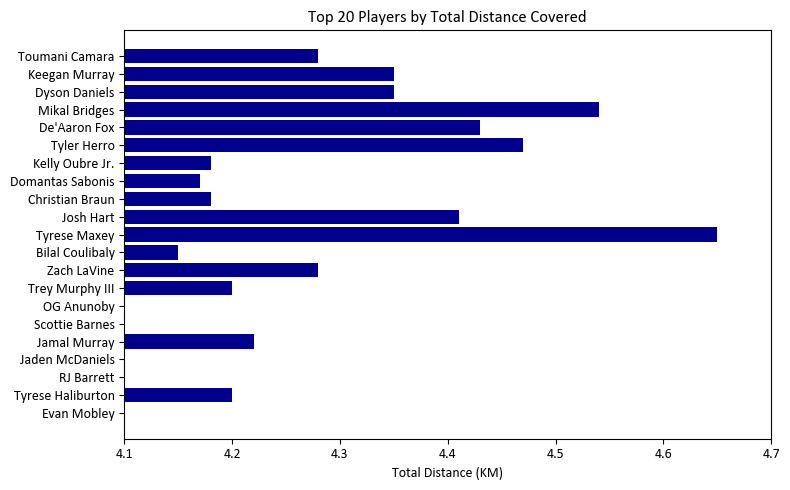

In [158]:
plt.figure(figsize=(8, 5))
plt.barh(top20_dist_km['Player'], top20_dist_km['Dist. KM'], color='darkblue')
plt.xlabel('Total Distance (KM)')
plt.title('Top 20 Players by Total Distance Covered')
plt.xlim(4.1, 4.7)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

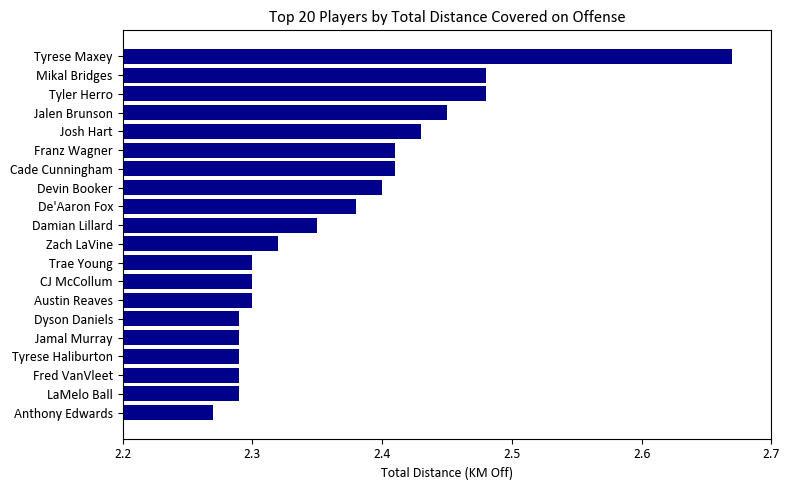

In [159]:
plt.figure(figsize=(8, 5))
plt.barh(top20_dist_km_off['Player'], top20_dist_km_off['Dist. KM Off'], color='darkblue')
plt.xlabel('Total Distance (KM Off)')
plt.title('Top 20 Players by Total Distance Covered on Offense')
plt.xlim(2.2, 2.7)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

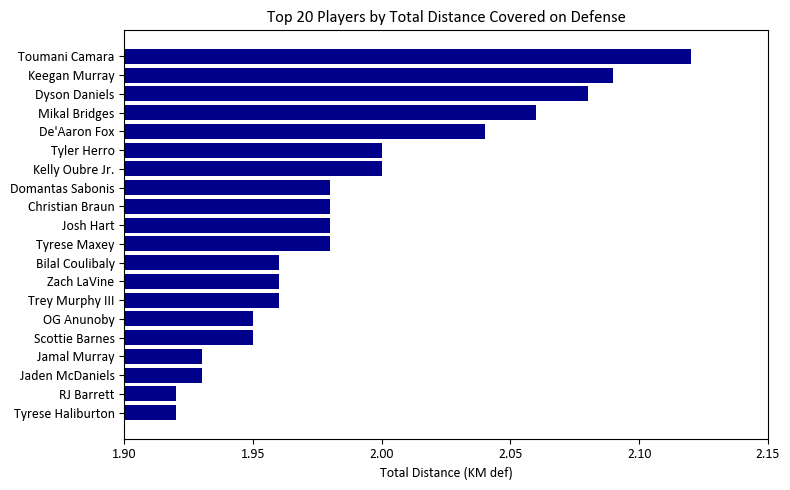

In [160]:
plt.figure(figsize=(8, 5))
plt.barh(top20_dist_km_def['Player'], top20_dist_km_def['Dist. KM Def'], color='darkblue')
plt.xlabel('Total Distance (KM def)')
plt.title('Top 20 Players by Total Distance Covered on Defense')
plt.xlim(1.9, 2.15)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

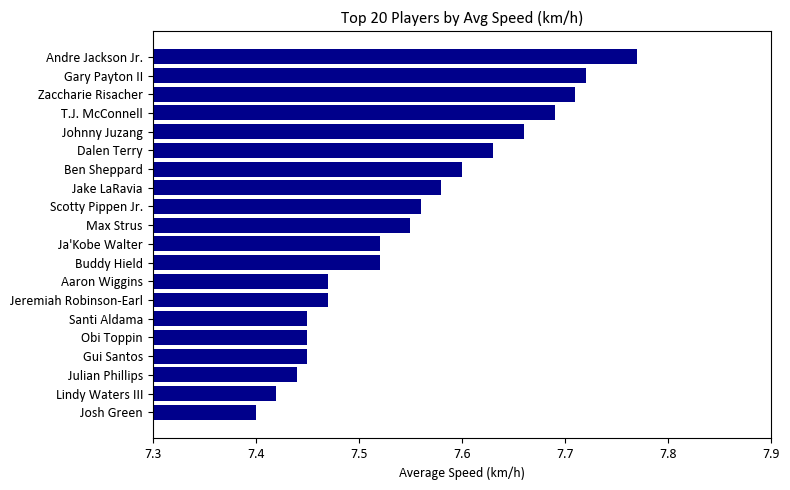

In [161]:
plt.figure(figsize=(8, 5))
plt.barh(top20_speed['Player'], top20_speed['Avg Speed (km/h)'], color='darkblue')
plt.xlabel('Average Speed (km/h)')
plt.title('Top 20 Players by Avg Speed (km/h)')
plt.xlim(7.3, 7.9)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

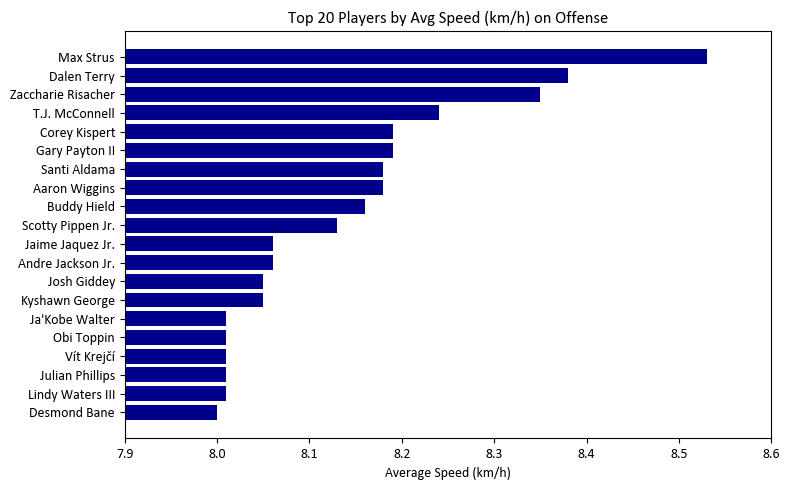

In [162]:
plt.figure(figsize=(8, 5))
plt.barh(top20_speed_off['Player'], top20_speed_off['Avg Speed (km/h) Off'], color='darkblue')
plt.xlabel('Average Speed (km/h)')
plt.title('Top 20 Players by Avg Speed (km/h) on Offense')
plt.xlim(7.9, 8.6)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [163]:
"""
plt.figure(figsize=(8, 5))
plt.barh(top20_speed_def['Player'], top20_speed_def['Avg Speed (km/h) Def'], color='darkblue')
plt.xlabel('Average Speed (km/h) Def')
plt.title('Top 20 Players by Avg Speed (km/h) on Defense')
plt.xlim(6.9, 7.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
"""

"\nplt.figure(figsize=(8, 5))\nplt.barh(top20_speed_def['Player'], top20_speed_def['Avg Speed (km/h) Def'], color='darkblue')\nplt.xlabel('Average Speed (km/h) Def')\nplt.title('Top 20 Players by Avg Speed (km/h) on Defense')\nplt.xlim(6.9, 7.5)\nplt.gca().invert_yaxis()\nplt.tight_layout()\nplt.show()\n"

## Per 36

In [164]:
# Identify duplicate columns — keep first, mark duplicates as True
dup_cols = combined_ows_dws.columns.duplicated(keep='first')

# Drop those duplicate columns
combined_ows_dws = combined_ows_dws.loc[:, ~dup_cols]

In [165]:
combined_ows_dws['Distance KM PER36'] = combined_ows_dws['Dist. KM'] * 36 / combined_ows_dws['MIN']
combined_ows_dws['Distance KM PER36 Off'] = combined_ows_dws['Dist. KM Off'] * 36 / combined_ows_dws['MIN']
combined_ows_dws['Distance KM PER36 Def'] = combined_ows_dws['Dist. KM Def'] * 36 / combined_ows_dws['MIN']
combined_ows_dws['Distance KM PER36'] = combined_ows_dws['Distance KM PER36'].round(2) 
combined_ows_dws['Distance KM PER36 Off'] = combined_ows_dws['Distance KM PER36 Off'].round(2)
combined_ows_dws['Distance KM PER36 Def'] = combined_ows_dws['Distance KM PER36 Def'].round(2)

C:\Users\modri\AppData\Local\Temp\ipykernel_9604\4080391950.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_ows_dws['Distance KM PER36'] = combined_ows_dws['Dist. KM'] * 36 / combined_ows_dws['MIN']
C:\Users\modri\AppData\Local\Temp\ipykernel_9604\4080391950.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_ows_dws['Distance KM PER36 Off'] = combined_ows_dws['Dist. KM Off'] * 36 / combined_ows_dws['MIN']
C:\Users\modri\AppData\Local\Temp\ipykernel_9604\4080391950.py:3: SettingWithCop

In [166]:
# Calculate correlation between Distance PER36 and 'WS'
correlation_5 = combined_ows_dws['Distance KM PER36'].corr(combined_ows_dws['WS'])
print(f"Correlation between Distance PER36 and WS: {correlation_5:.3f}")

Correlation between Distance PER36 and WS: -0.461


In [167]:
# Calculate correlation between Distance PER36 and 'WS'
correlation_6 = combined_ows_dws['Distance KM PER36 Off'].corr(combined_ows_dws['OWS'])
print(f"Correlation between Distance on Offence PER36 and WS: {correlation_6:.3f}")

Correlation between Distance on Offence PER36 and WS: -0.363


In [168]:
# Calculate correlation between Distance PER36 and 'WS'
correlation_7 = combined_ows_dws['Distance KM PER36 Def'].corr(combined_ows_dws['DWS'])
print(f"Correlation between Distance on Defence PER36 and WS: {correlation_7:.3f}")

Correlation between Distance on Defence PER36 and WS: -0.244


In [169]:
# Calculate the combined correlation (multiple correlation coefficient, R) between 'Dist. KM Off' and 'Avg Speed (km/h) Off' with 'OWS'

# Select relevant columns and drop NA if any
cols_2 = ['Distance KM PER36 Off', 'Avg Speed (km/h) Off', 'OWS']
df_corr_2 = combined_ows_dws[cols_2].dropna()

# Calculate the multiple correlation coefficient (R)
corr_matrix_2 = df_corr_2.corr()
r_yx1 = corr_matrix_2.loc['OWS', 'Distance KM PER36 Off']
r_yx2 = corr_matrix_2.loc['OWS', 'Avg Speed (km/h) Off']
r_x1x2 = corr_matrix_2.loc['Distance KM PER36 Off', 'Avg Speed (km/h) Off']

# Formula for multiple correlation coefficient R_y.x1x2
numerator = r_yx1**2 + r_yx2**2 - 2*r_yx1*r_yx2*r_x1x2
denominator = 1 - r_x1x2**2
R = sqrt(numerator / denominator)

print(f"Combined multiple correlation (R) between Distance KM PER36 Off, Avg Speed (km/h) Off and OWS: {R:.3f}")

Combined multiple correlation (R) between Distance KM PER36 Off, Avg Speed (km/h) Off and OWS: 0.384


In [170]:
# Calculate the combined correlation (multiple correlation coefficient, R) between 'Distance KM PER36 Def' and 'Avg Speed (km/h) Def' with 'DWS'

# Select relevant columns and drop NA if any
cols_2 = ['Distance KM PER36 Def', 'Avg Speed (km/h) Def', 'DWS']
df_corr_2 = combined_ows_dws[cols_2].dropna()

# Calculate the multiple correlation coefficient (R)
corr_matrix_2 = df_corr_2.corr()
r_yx1 = corr_matrix_2.loc['DWS', 'Distance KM PER36 Def']
r_yx2 = corr_matrix_2.loc['DWS', 'Avg Speed (km/h) Def']
r_x1x2 = corr_matrix_2.loc['Distance KM PER36 Def', 'Avg Speed (km/h) Def']

# Formula for multiple correlation coefficient R_y.x1x2
numerator = r_yx1**2 + r_yx2**2 - 2*r_yx1*r_yx2*r_x1x2
denominator = 1 - r_x1x2**2
R = sqrt(numerator / denominator)

print(f"Combined multiple correlation (R) between Distance KM PER36 Def, Avg Speed (km/h) Def and DWS: {R:.3f}")

Combined multiple correlation (R) between Distance KM PER36 Def, Avg Speed (km/h) Def and DWS: 0.312


In [171]:
# Calculate the correlation between Distance KM PER36 Off, Distance KM PER36 Def, Avg Speed (km/h) Def, Avg Speed (km/h) Off and WS

# Select relevant columns and drop NA if any
cols_ws = ['Distance KM PER36 Off', 'Distance KM PER36 Def', 'Avg Speed (km/h) Def', 'Avg Speed (km/h) Off', 'WS']
df_corr_ws = combined_ows_dws[cols_ws].dropna()

# Compute correlation matrix
corr_matrix_ws = df_corr_ws.corr()

# Print correlation of each variable with WS
print(corr_matrix_ws['WS'])

Distance KM PER36 Off   -0.427121
Distance KM PER36 Def   -0.386227
Avg Speed (km/h) Def    -0.443578
Avg Speed (km/h) Off    -0.311725
WS                       1.000000
Name: WS, dtype: float64


In [172]:
# Select relevant columns and drop NA if any
cols_ws = ['Distance KM PER36 Off', 'Distance KM PER36 Def', 'Avg Speed (km/h) Def', 'Avg Speed (km/h) Off', 'WS']
df_corr_ws = combined_ows_dws[cols_ws].dropna()

# Compute the correlation matrix
corr_matrix_ws = df_corr_ws.corr()

# Calculate the multiple correlation coefficient (R) for WS with the other variables

# Extract correlation submatrices
r_yx = corr_matrix_ws.loc['WS', df_corr_ws.columns.difference(['WS'])]
R_xx = corr_matrix_ws.loc[df_corr_ws.columns.difference(['WS']), df_corr_ws.columns.difference(['WS'])]

# Multiple correlation coefficient formula
R_squared = r_yx.values @ inv(R_xx.values) @ r_yx.values.T
R = np.sqrt(R_squared)

print(f"Multiple correlation coefficient (R) between predictors and WS: {R:.3f}")

Multiple correlation coefficient (R) between predictors and WS: 0.550


In [173]:
team_summary_kmh

,TEAM,Weighted Mean Speed (km/h)
0,MEM,7.13
1,IND,7.12
2,TOR,7.11
3,ATL,7.06
4,GSW,7.03
5,BKN,7.00
6,CHI,7.00
7,WAS,7.00
8,NOP,6.97
9,CLE,6.95


In [174]:
dfs_columns = [team_summary, team_summary_def, team_summary_kmh, team_summary_kmh_def, team_summary_kmh_off, team_summary_off]
all_columns = set()
for df in dfs_columns:
    all_columns.update(df.columns)
print(sorted(all_columns))

['TEAM', 'Weighted Mean Dist (KM) Def', 'Weighted Mean Dist (KM) Off', 'Weighted Mean Speed (km/h)', 'Weighted Mean Speed (km/h) Def', 'Weighted Mean Speed (km/h) Off', 'Win PCT']


In [175]:
team_summary_kmh_off

,TEAM,Weighted Mean Speed (km/h) Off
0,ATL,7.76
1,CHI,7.71
2,MEM,7.64
3,IND,7.61
4,TOR,7.59
5,WAS,7.58
6,CLE,7.56
7,GSW,7.55
8,OKC,7.48
9,NOP,7.40


In [ ]:
# Define features and target
features = [
    'Weighted Mean Dist (KM) Def',
    'Weighted Mean Dist (KM) Off',
    'Weighted Mean Speed (km/h) Def',
    'Weighted Mean Speed (km/h) Off'
]
target = 'Win PCT'

# Step 1: Refit the model using raw features
X = combined_df[features]
y = combined_df[target]
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()

# Step 2: Get ATL's offensive speed
atl_speed = team_summary_kmh_off[team_summary_kmh_off['TEAM'] == 'ATL']['Weighted Mean Speed (km/h) Off'].values[0]

# Step 3: Get OKC's row and modify it
okc_features = combined_df[combined_df['TEAM'] == 'OKC'][features].copy()
okc_features['Weighted Mean Speed (km/h) Off'] = atl_speed

# Step 4: Add intercept
okc_features_const = sm.add_constant(okc_features, has_constant='add')

# Step 5: Predict
okc_pred_win_pct = model.predict(okc_features_const)[0]
print(f"Predicted OKC Win % if Off Speed = ATL ({atl_speed} km/h): {okc_pred_win_pct:.2f}")


KeyError: 0

In [ ]:
# Refit the model
features = [
    'Weighted Mean Dist (KM) Def',
    'Weighted Mean Dist (KM) Off',
    'Weighted Mean Speed (km/h) Def',
    'Weighted Mean Speed (km/h) Off'
]
X = combined_df[features]
y = combined_df['Win PCT']
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()

# Get ATL’s off speed
atl_speed = team_summary_kmh_off[team_summary_kmh_off['TEAM'] == 'ATL']['Weighted Mean Speed (km/h) Off'].values[0]

# Get OKC’s row and modify
okc_features = combined_df[combined_df['TEAM'] == 'OKC'][features].copy()
okc_features['Weighted Mean Speed (km/h) Off'] = atl_speed

# Force add intercept
okc_features_const = sm.add_constant(okc_features, has_constant='add')

# Predict
okc_pred_win_pct = model.predict(okc_features_const).values[0]
print(f"Predicted OKC Win % if Off Speed = ATL ({atl_speed} km/h): {okc_pred_win_pct:.2f}")


Predicted OKC Win % if Off Speed = ATL (7.76 km/h): 50.14


In [ ]:

features = [
    'Weighted Mean Dist (KM) Def',
    'Weighted Mean Dist (KM) Off',
    'Weighted Mean Speed (km/h) Def',
    'Weighted Mean Speed (km/h) Off'
]

# Fit the model once
X = combined_df[features]
y = combined_df['Win PCT']
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()

# Get OKC's original features (copy to avoid modifying original)
okc_features = combined_df[combined_df['TEAM'] == 'OKC'][features].copy()

# We'll keep all OKC features except offensive speed which we'll replace each iteration
okc_features_base = okc_features.iloc[0].copy()  # Series of OKC features

# Get all teams offensive speed (for substitution)
teams_off_speed = combined_df[['TEAM', 'Weighted Mean Speed (km/h) Off']]

results = []

for _, row in teams_off_speed.iterrows():
    team_name = row['TEAM']
    substituted_speed = row['Weighted Mean Speed (km/h) Off']

    # Replace OKC's offensive speed with this team's value
    features_mod = okc_features_base.copy()
    features_mod['Weighted Mean Speed (km/h) Off'] = substituted_speed

    # Convert to DataFrame for model input and add constant
    features_mod_df = pd.DataFrame([features_mod])
    features_mod_df_const = sm.add_constant(features_mod_df, has_constant='add')

    # Predict OKC's win percentage with substituted speed
    pred_win_pct = model.predict(features_mod_df_const).iloc[0]

    results.append({'Team Used for Off Speed': team_name, 'Predicted OKC Win %': pred_win_pct})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

print(results_df)


   Team Used for Off Speed  Predicted OKC Win %
0                      NYK            63.209375
1                      SAC            57.400748
2                      ATL            50.139963
3                      NOP            56.674669
4                      DEN            61.757218
5                      BKN            56.674669
6                      UTA            60.305061
7                      MIN            60.668101
8                      TOR            53.225797
9                      POR            60.123542
10                     MIA            57.219228
11                     SAS            56.674669
12                     PHI            60.305061
13                     DAL            59.397463
14                     DET            59.397463
15                     CHA            58.308346
16                     HOU            62.120258
17                     ORL            60.305061
18                     PHX            59.578983
19                     BOS            67

In [ ]:
features = [
    'Weighted Mean Dist (KM) Def',
    'Weighted Mean Dist (KM) Off',
    'Weighted Mean Speed (km/h) Def',
    'Weighted Mean Speed (km/h) Off'
]

# Fit the model on all teams
X = combined_df[features]
y = combined_df['Win PCT']
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()

# OKC baseline features (all except the two speed features we'll swap)
okc_features = combined_df[combined_df['TEAM'] == 'OKC'][features].iloc[0].copy()

# Get all teams' Off and Def speeds
teams_speed = combined_df[['TEAM', 'Weighted Mean Speed (km/h) Off', 'Weighted Mean Speed (km/h) Def']]

results = []

for _, off_row in teams_speed.iterrows():
    off_team = off_row['TEAM']
    off_speed = off_row['Weighted Mean Speed (km/h) Off']
    
    for _, def_row in teams_speed.iterrows():
        def_team = def_row['TEAM']
        def_speed = def_row['Weighted Mean Speed (km/h) Def']
        
        # Copy OKC features and replace the two speeds
        features_mod = okc_features.copy()
        features_mod['Weighted Mean Speed (km/h) Off'] = off_speed
        features_mod['Weighted Mean Speed (km/h) Def'] = def_speed
        
        # Prepare DataFrame and add constant
        features_mod_df = pd.DataFrame([features_mod])
        features_mod_df_const = sm.add_constant(features_mod_df, has_constant='add')
        
        # Predict OKC Win %
        pred_win_pct = model.predict(features_mod_df_const).iloc[0]
        
        results.append({
            'Off Speed Team': off_team,
            'Def Speed Team': def_team,
            'Predicted OKC Win %': pred_win_pct
        })

results_df = pd.DataFrame(results)

print(results_df)


    Off Speed Team Def Speed Team  Predicted OKC Win %
0              NYK            NYK            63.641524
1              NYK            SAC            63.641524
2              NYK            ATL            63.209375
3              NYK            NOP            57.591437
4              NYK            DEN            74.445253
..             ...            ...                  ...
895            MEM            CLE            52.750348
896            MEM            CHI            54.046795
897            MEM            GSW            47.996707
898            MEM            LAL            54.911093
899            MEM            MEM            41.946620

[900 rows x 3 columns]


In [ ]:
results_df['Predicted OKC Win %'] = results_df['Predicted OKC Win %'].round(2)

In [ ]:
results_df['Predicted OKC Win %'] = results_df['Predicted OKC Win %'].sort_values(ascending=False)

In [ ]:
results_df['Predicted OKC Win %'] = results_df.reset_index(drop=True)

In [179]:
features = [
    'Weighted Mean Dist (KM) Def',
    'Weighted Mean Dist (KM) Off',
    'Weighted Mean Speed (km/h) Def',
    'Weighted Mean Speed (km/h) Off'
]

# Fit the model
X = combined_df[features]
y = combined_df['Win PCT']
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()

# OKC's baseline features (copy first row)
okc_features = (
    combined_df.loc[combined_df['TEAM'] == 'OKC', features]
    .assign(**{'Weighted Mean Speed (km/h) Off': atl_speed})
    .reset_index(drop=True)      # gives it label 0
)
okc_features_const = sm.add_constant(okc_features, has_constant='add')
okc_pred_win_pct = model.predict(okc_features_const)[0]  # now label 0 exists

# Prepare a dict of each feature's team values
feature_team_values = {}
for feat in features:
    feature_team_values[feat] = combined_df[['TEAM', feat]].set_index('TEAM')[feat]

teams = combined_df['TEAM'].unique()

results = []

for dist_def_team in teams:
    dist_def_val = feature_team_values['Weighted Mean Dist (KM) Def'].loc[dist_def_team]
    for dist_off_team in teams:
        dist_off_val = feature_team_values['Weighted Mean Dist (KM) Off'].loc[dist_off_team]
        for speed_def_team in teams:
            speed_def_val = feature_team_values['Weighted Mean Speed (km/h) Def'].loc[speed_def_team]
            for speed_off_team in teams:
                speed_off_val = feature_team_values['Weighted Mean Speed (km/h) Off'].loc[speed_off_team]

                # Make a copy of OKC features and replace all four features
                features_mod = okc_features.copy()
                features_mod['Weighted Mean Dist (KM) Def'] = dist_def_val
                features_mod['Weighted Mean Dist (KM) Off'] = dist_off_val
                features_mod['Weighted Mean Speed (km/h) Def'] = speed_def_val
                features_mod['Weighted Mean Speed (km/h) Off'] = speed_off_val

                features_mod_df = features_mod.copy()
                features_mod_df_const = sm.add_constant(features_mod_df, has_constant='add')

                pred_win_pct = model.predict(features_mod_df_const).iloc[0]

                results.append({
                    'Dist Def Team': dist_def_team,
                    'Dist Off Team': dist_off_team,
                    'Speed Def Team': speed_def_team,
                    'Speed Off Team': speed_off_team,
                    'Predicted OKC Win %': pred_win_pct
                })

results_df = pd.DataFrame(results)
print(results_df)


       Dist Def Team Dist Off Team Speed Def Team Speed Off Team  \
0                NYK           NYK            NYK            NYK   
1                NYK           NYK            NYK            SAC   
2                NYK           NYK            NYK            ATL   
3                NYK           NYK            NYK            NOP   
4                NYK           NYK            NYK            DEN   
...              ...           ...            ...            ...   
809995           MEM           MEM            MEM            CLE   
809996           MEM           MEM            MEM            CHI   
809997           MEM           MEM            MEM            GSW   
809998           MEM           MEM            MEM            LAL   
809999           MEM           MEM            MEM            MEM   

        Predicted OKC Win %  
0                 36.394770  
1                 30.586142  
2                 23.325358  
3                 29.860064  
4                 34.942613  
...

In [180]:
# Sort results_df by 'Predicted OKC Win %' in descending order
results_df_sorted = results_df.sort_values(by='Predicted OKC Win %', ascending=False).reset_index(drop=True)
print(results_df_sorted)

       Dist Def Team Dist Off Team Speed Def Team Speed Off Team  \
0                SAC           MEM            DEN            BOS   
1                SAC           MEM            DEN            LAL   
2                SAC           MEM            DEN            LAC   
3                SAC           MEM            DEN            NYK   
4                ATL           MEM            DEN            BOS   
...              ...           ...            ...            ...   
809995           GSW           NYK            TOR            ATL   
809996           LAL           NYK            MEM            ATL   
809997           GSW           NYK            MEM            ATL   
809998           GSW           NYK            IND            ATL   
809999           LAL           NYK            IND            ATL   

        Predicted OKC Win %  
0                117.895284  
1                115.354009  
2                114.446411  
3                113.538813  
4                113.290552  
...

In [ ]:
results_df.round(2)

,Dist Def Team,Dist Off Team,Speed Def Team,Speed Off Team,Predicted OKC Win %
0,NYK,NYK,NYK,NYK,36.39
1,NYK,NYK,NYK,SAC,30.59
2,NYK,NYK,NYK,ATL,23.33
3,NYK,NYK,NYK,NOP,29.86
4,NYK,NYK,NYK,DEN,34.94
...,...,...,...,...,...
809995,MEM,MEM,MEM,CLE,57.93
809996,MEM,MEM,MEM,CHI,55.21
809997,MEM,MEM,MEM,GSW,58.12
809998,MEM,MEM,MEM,LAL,69.19


In [184]:

results_df_sorted = results_df.sort_values(by='Predicted OKC Win %', ascending=False).round(2).reset_index(drop=True)
print(results_df_sorted)

       Dist Def Team Dist Off Team Speed Def Team Speed Off Team  \
0                SAC           MEM            DEN            BOS   
1                SAC           MEM            DEN            LAL   
2                SAC           MEM            DEN            LAC   
3                SAC           MEM            DEN            NYK   
4                ATL           MEM            DEN            BOS   
...              ...           ...            ...            ...   
809995           GSW           NYK            TOR            ATL   
809996           LAL           NYK            MEM            ATL   
809997           GSW           NYK            MEM            ATL   
809998           GSW           NYK            IND            ATL   
809999           LAL           NYK            IND            ATL   

        Predicted OKC Win %  
0                    117.90  
1                    115.35  
2                    114.45  
3                    113.54  
4                    113.29  
...